Đang đọc và làm sạch dữ liệu từ: ../Digilog

Đã tải và làm sạch thành công 8 tệp cho đội 'Digilog'.

Bắt đầu gộp và tiền xử lý dữ liệu...
Gộp dữ liệu gốc hoàn tất.

Áp dụng kỹ thuật sai phân để xử lý dữ liệu không ổn định...
Tạo dữ liệu sai phân và đặc trưng hoàn tất.
Kích thước bộ dữ liệu mới: (162, 35)

--- Bắt đầu huấn luyện cho Heat_cons (dự đoán Heat_cons_diff) ---
Tập huấn luyện: 48 mẫu, Tập kiểm tra: 114 mẫu
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 8
[LightGBM] [Info] Start training from score 0.025969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

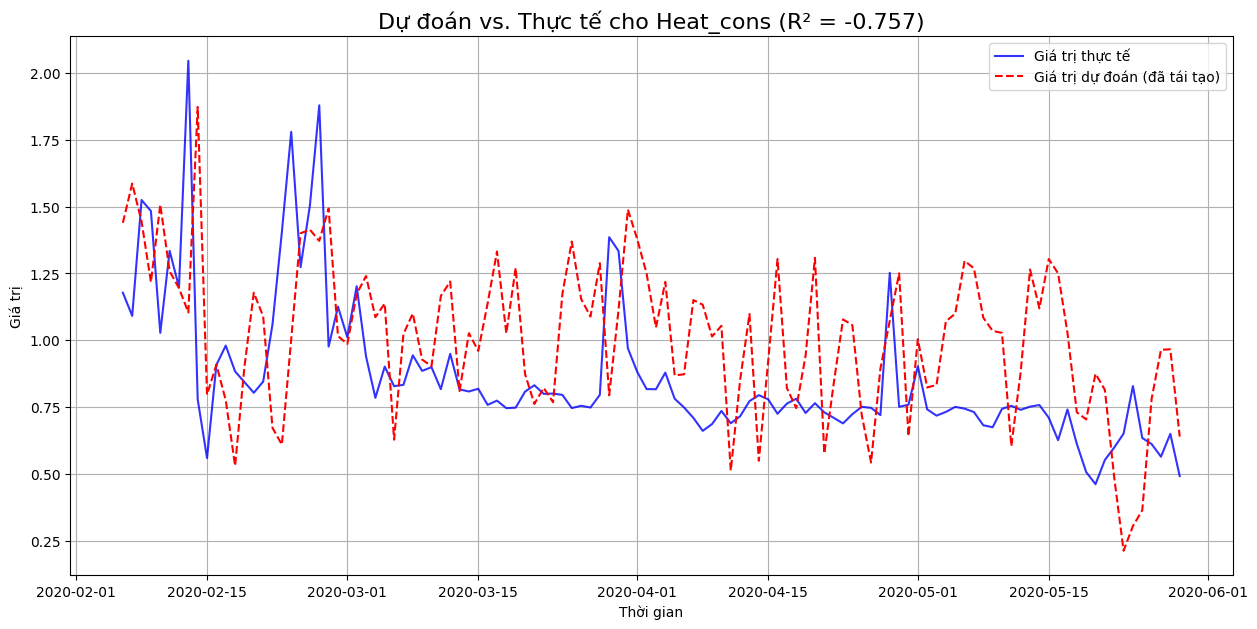

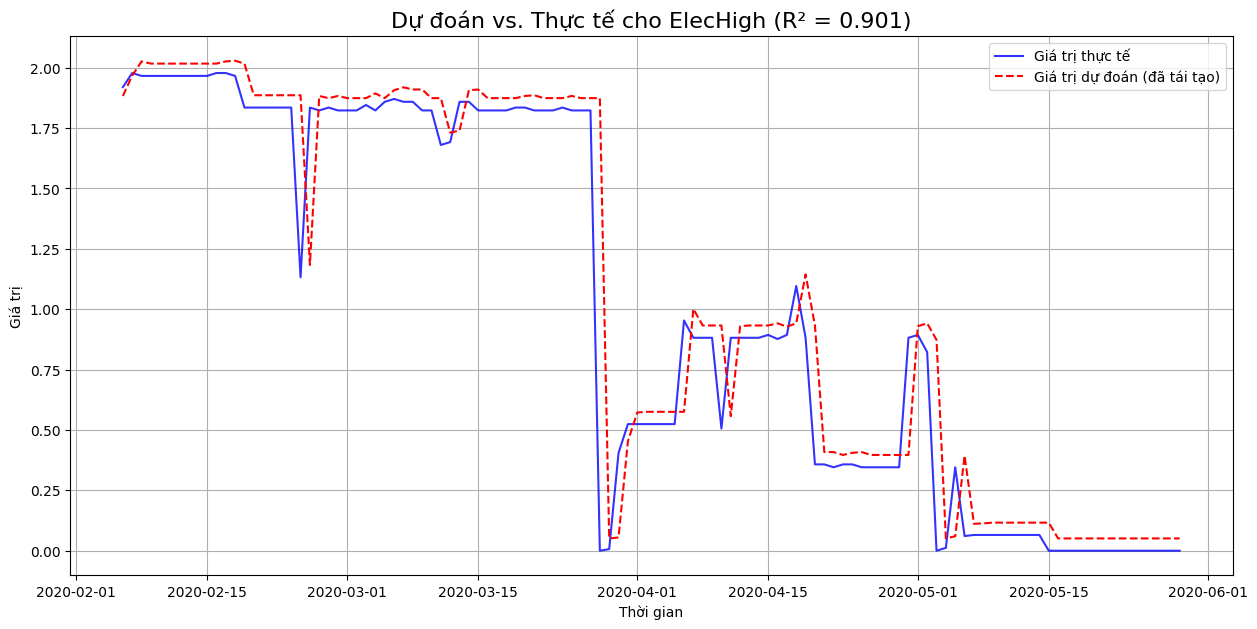

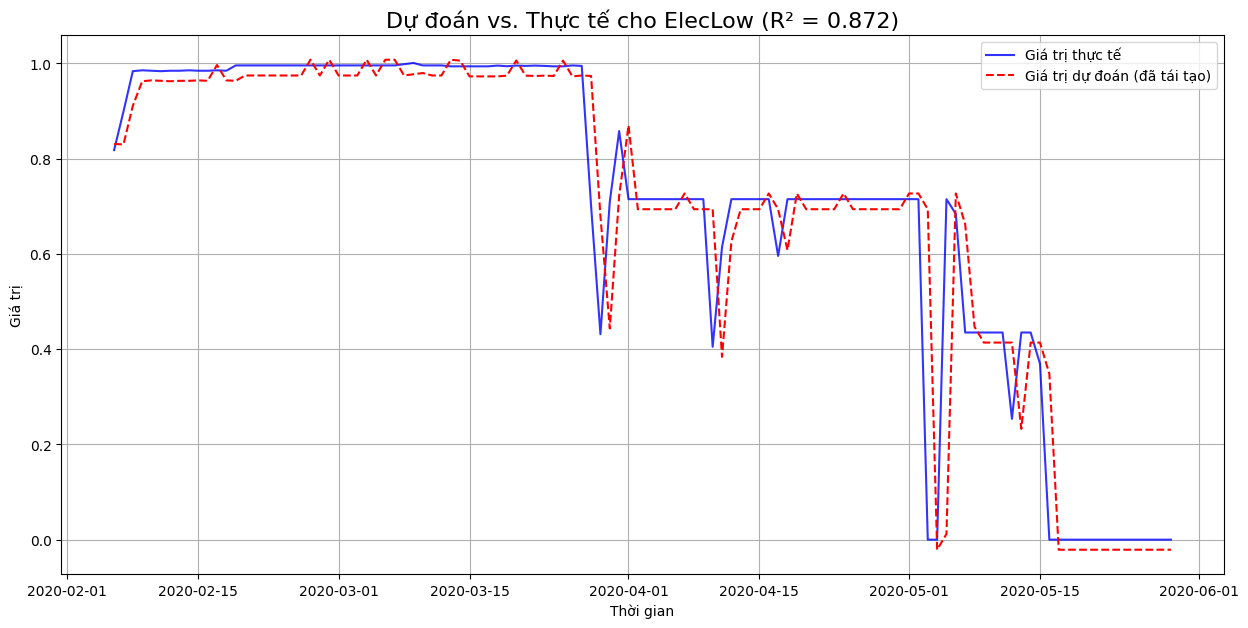

In [ ]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')


# 2. DATA LOADING & AUTOMATIC CLEANING (Không thay đổi)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    print(f"Đang đọc và làm sạch dữ liệu từ: {folder_path}")
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
        
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"

team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

print(f"\nĐã tải và làm sạch thành công {len(team_data)} tệp cho đội '{TEAM_TO_ANALYZE}'.")


# 3. DATA MERGING & PREPROCESSING (Không thay đổi)
# ==============================================================================
print("\nBắt đầu gộp và tiền xử lý dữ liệu...")
df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else:
        raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_original = df_resources.join([df_climate, df_weather], how='inner')
for col in df_original.columns:
    df_original[col] = pd.to_numeric(df_original[col], errors='coerce')

df_original.dropna(axis=1, how='all', inplace=True)
df_original.ffill(inplace=True)
print("Gộp dữ liệu gốc hoàn tất.")


# 4. CHIẾN LƯỢC MỚI: TẠO DỮ LIỆU SAI PHÂN (DIFFERENCING)
# ==============================================================================
print("\nÁp dụng kỹ thuật sai phân để xử lý dữ liệu không ổn định...")

# Lấy sai phân cho các biến mục tiêu và các biến có xu hướng
df = pd.DataFrame(index=df_original.index)

# Các cột cần sai phân (bao gồm cả target và feature)
cols_to_diff = ['Heat_cons', 'ElecHigh', 'ElecLow', 'Tout', 'Tair', 'Iglob', 'PipeLow', 'PipeGrow', 'Rhair']

for col in cols_to_diff:
    if col in df_original.columns:
        df[f'{col}_diff'] = df_original[col].diff()

# Các cột không cần sai phân (vì chúng không có xu hướng hoặc đã ổn định)
# Ví dụ: setpoints, cyclical features, actuators status
cols_to_keep_original = [
    't_heat_sp', 'Assim_sp', 'AssimLight', 'int_blue_sp', 'int_red_sp', 
    'int_farred_sp', 'int_white_sp', 'Windsp'
]

for col in cols_to_keep_original:
    if col in df_original.columns:
        df[col] = df_original[col]

# Tạo các đặc trưng thời gian
df['hour'] = df.index.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_of_year'] = df.index.dayofyear

# Tạo lag features TRÊN DỮ LIỆU ĐÃ SAI PHÂN
for col in ['Heat_cons_diff', 'ElecHigh_diff', 'ElecLow_diff', 'Tair_diff', 'Tout_diff']:
     if col in df.columns:
        for i in range(1, 4):
            df[f'{col}_lag_{i}'] = df[col].shift(i)

# Bỏ các dòng NaN được tạo ra do .diff() và .shift()
df.dropna(inplace=True)
print("Tạo dữ liệu sai phân và đặc trưng hoàn tất.")
print(f"Kích thước bộ dữ liệu mới: {df.shape}")


# 5. MODELING VỚI DỮ LIỆU SAI PHÂN
# ==============================================================================
def train_and_evaluate_diff(target_name, features, data, original_data):
    """
    Huấn luyện mô hình trên dữ liệu sai phân, sau đó chuyển đổi ngược để đánh giá.
    """
    target_diff = f'{target_name}_diff'
    print(f"\n--- Bắt đầu huấn luyện cho {target_name} (dự đoán {target_diff}) ---")
    
    available_features = [f for f in features if f in data.columns]
    X = data[available_features]
    y = data[target_diff]
    
    # Chia train/test theo thời gian
    split_index = int(len(X) * 0.3)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    print(f"Tập huấn luyện: {len(X_train)} mẫu, Tập kiểm tra: {len(X_test)} mẫu")
    
    # Huấn luyện mô hình
    lgbm = lgb.LGBMRegressor(random_state=42)
    lgbm.fit(X_train, y_train)

    # rf = RandomForestRegressor(n_estimators=100,random_state=42)
    # rf.fit(X_train, y_train)

    # Dự đoán giá trị sai phân (_diff)
    y_pred_diff = lgbm.predict(X_test)
    previous_actual_values = original_data[target_name].loc[y_test.index].shift(1)
    # Giá trị đầu tiên của chuỗi test cần giá trị cuối cùng của chuỗi train
    first_test_timestamp = y_test.index[0]
    last_train_timestamp_index = original_data.index.get_loc(first_test_timestamp) - 1
    last_train_value = original_data[target_name].iloc[last_train_timestamp_index]
    previous_actual_values.iloc[0] = last_train_value
    y_pred_reconstructed = previous_actual_values + y_pred_diff
    
    # Lấy giá trị thực tế (không sai phân) để so sánh
    y_actual_original = original_data[target_name].loc[y_test.index]
    
    # Đánh giá trên dữ liệu đã được tái tạo    rmse = np.sqrt(mean_squared_error(y_actual_original, y_pred_reconstructed))
    r2 = r2_score(y_actual_original, y_pred_reconstructed)
    print(f"KẾT QUẢ CHO {target_name}:")
    # print(f"  Test RMSE (trên giá trị gốc): {rmse:.4f}")
    print(f"  Test R² (trên giá trị gốc): {r2:.4f}  <-- HY VỌNG SỐ NÀY SẼ DƯƠNG!")
    
    # Trả về kết quả để vẽ biểu đồ
    results = {
        'model': lgbm,
        'y_actual': y_actual_original,
        'y_pred': y_pred_reconstructed,
        'r2_score': r2
    }
    return results

# --- Định nghĩa các bộ đặc trưng cho mô hình sai phân ---
heat_features_diff = [
    'Tout_diff', 'Tair_diff', 'Iglob', 'Windsp', 'PipeLow_diff', 'Rhair_diff', 
    't_heat_sp', # setpoints giữ nguyên
    'hour_sin', 'hour_cos',
    'Heat_cons_diff_lag_1', 'Heat_cons_diff_lag_2', 'Tair_diff_lag_1'
]

elec_features_diff = [
    'Iglob', 'PARout', 'Assim_sp', 'AssimLight', 'int_blue_sp', 'int_red_sp',
    'hour_sin', 'hour_cos', 'day_of_year',
    'ElecHigh_diff_lag_1', 'ElecLow_diff_lag_1', 'Iglob_lag_1' # I glob không cần diff
]

# --- Chạy mô hình ---
heat_results = train_and_evaluate_diff('Heat_cons', heat_features_diff, df, df_original)
elechigh_results = train_and_evaluate_diff('ElecHigh', elec_features_diff, df, df_original)
eleclow_results = train_and_evaluate_diff('ElecLow', elec_features_diff, df, df_original)


# 6. VISUALIZE RESULTS
# ==============================================================================
def plot_reconstructed_predictions(results, target_name):
    """Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán đã tái tạo."""
    plt.figure(figsize=(15, 7))
    plt.plot(results['y_actual'], label='Giá trị thực tế', color='blue', alpha=0.8)
    plt.plot(results['y_pred'], label='Giá trị dự đoán (đã tái tạo)', color='red', linestyle='--')
    
    plt.title(f'Dự đoán vs. Thực tế cho {target_name} (R² = {results["r2_score"]:.3f})', fontsize=16)
    plt.xlabel('Thời gian')
    plt.ylabel('Giá trị')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- Hiển thị kết quả trực quan ---")
plot_reconstructed_predictions(heat_results, 'Heat_cons')
plot_reconstructed_predictions(elechigh_results, 'ElecHigh')
plot_reconstructed_predictions(eleclow_results, 'ElecLow')


In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print('Result of Augmented Dickey Fuller: ')
    df_test= adfuller(timeseries, autolag = "AIC")
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations'])
    for key, value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)


In [40]:
adf_test(df_climate["int_red_sp"].astype("float").dropna())

Result of Augmented Dickey Fuller: 
Test Statistic           -1.313535e+01
p-value                   1.466031e-24
#Lags Used                5.300000e+01
Number of Observations    4.680100e+04
Critical Value (1%)      -3.430490e+00
Critical Value (5%)      -2.861602e+00
Critical Value (10%)     -2.566803e+00
dtype: float64


In [36]:
df_climate = df_climate.astype("float")
df_climate.dtypes

AssimLight                     float64
BlackScr                       float64
CO2air                         float64
Cum_irr                        float64
EC_drain_PC                    float64
EnScr                          float64
HumDef                         float64
PipeGrow                       float64
PipeLow                        float64
Rhair                          float64
Tair                           float64
Tot_PAR                        float64
Tot_PAR_Lamps                  float64
VentLee                        float64
Ventwind                       float64
assim_sp                       float64
assim_vip                      float64
co2_dos                        float64
co2_sp                         float64
co2_vip                        float64
dx_sp                          float64
dx_vip                         float64
int_blue_sp                    float64
int_blue_vip                   float64
int_farred_sp                  float64
int_farred_vip           

--- Bước 1: Trực quan hóa dữ liệu Heat_cons gốc ---


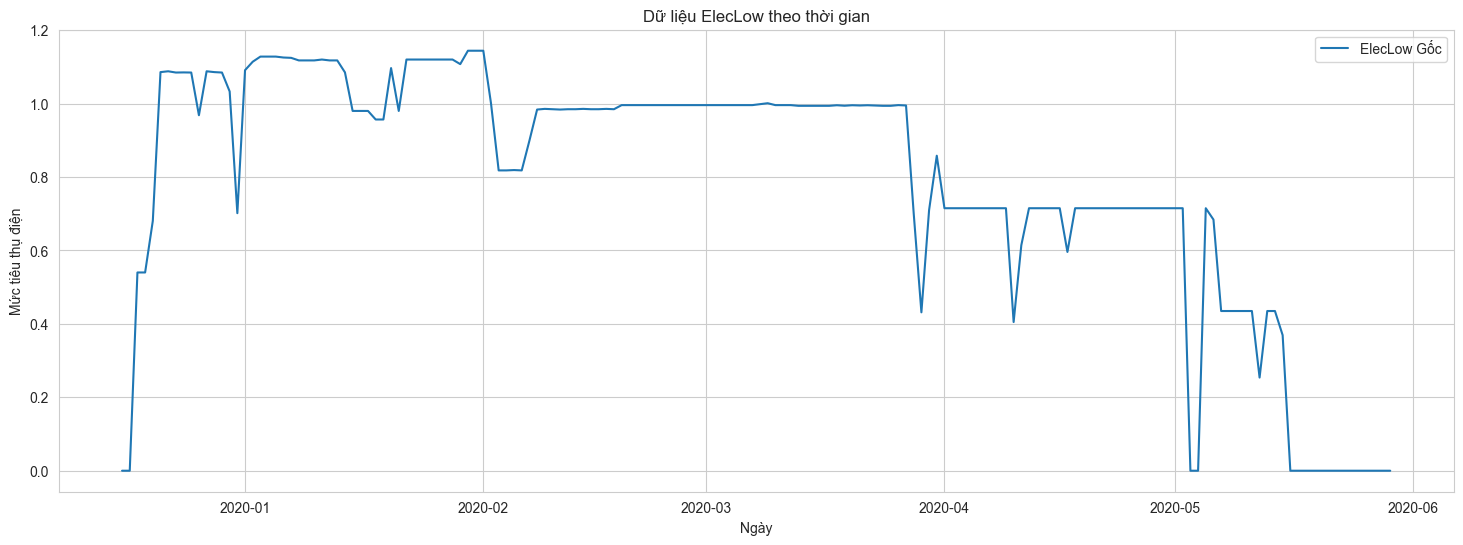


--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---
Tạo đặc trưng hoàn tất.

--- Bước 3: Chạy các mô hình và đánh giá ---

1. Đánh giá Baseline Model (Chỉ Lag Features)...
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 45, number of used features: 0
[LightGBM] [Info] Start training from score 0.981930
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] 

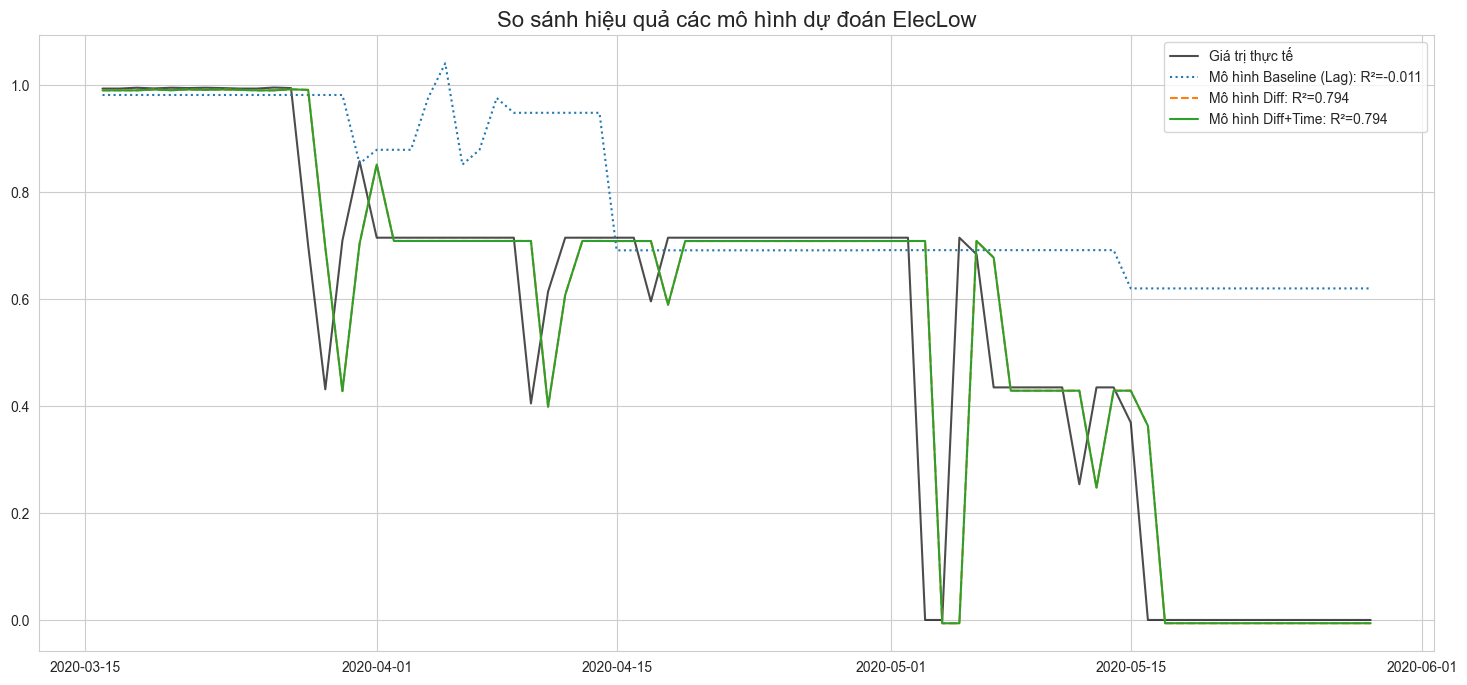


--- Bước 5: Phân tích Feature Importance của mô hình tốt nhất ---
                feature  importance
0    ElecLow_diff_lag_1           0
1    ElecLow_diff_lag_2           0
2    ElecLow_diff_lag_3           0
3    ElecLow_diff_lag_4           0
4    ElecLow_diff_lag_5           0
5    ElecLow_diff_lag_6           0
6    ElecLow_diff_lag_7           0
7    ElecLow_diff_lag_8           0
8    ElecLow_diff_lag_9           0
9   ElecLow_diff_lag_10           0
10  ElecLow_diff_lag_11           0
11  ElecLow_diff_lag_12           0
12             hour_sin           0
13             hour_cos           0


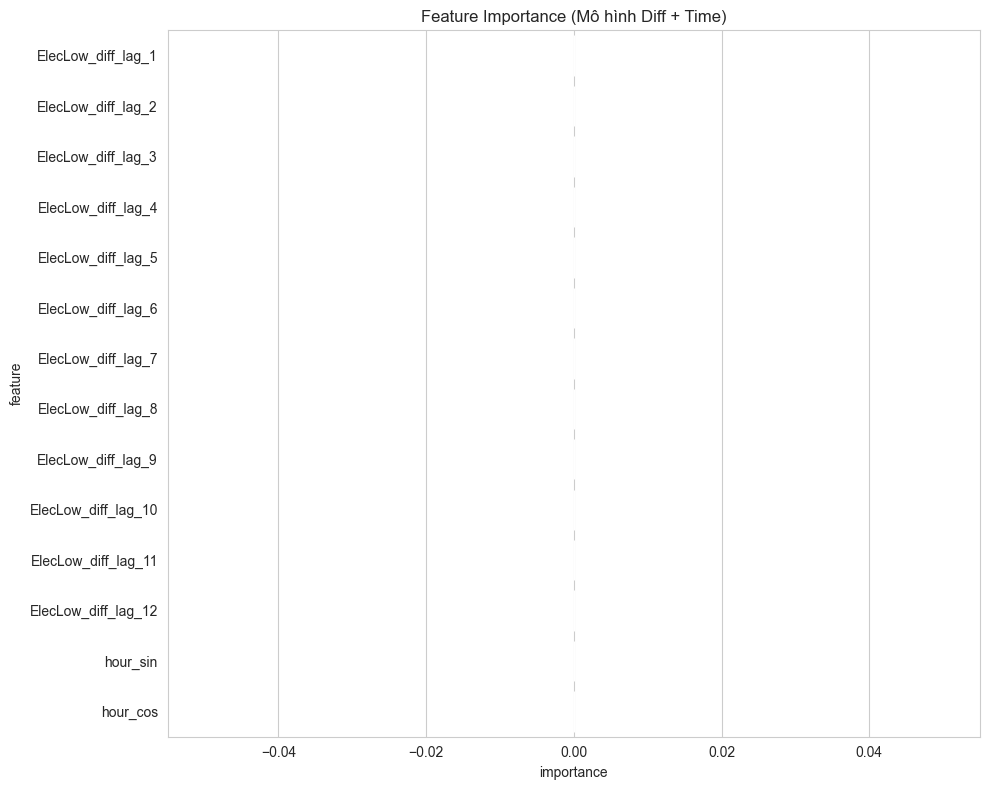

In [75]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_resources = team_data['Resources.csv'].copy()
time_col = next((col for col in df_resources.columns if col.lower() == 'time'), None)
if time_col:
    df_resources[time_col] = pd.to_numeric(df_resources[time_col], errors='coerce')
    df_resources['datetime'] = pd.to_datetime(df_resources[time_col], unit='D', origin='1899-12-30')
    df_resources.set_index('datetime', inplace=True)
else:
    raise KeyError("Không tìm thấy cột Time.")

data = df_resources[['ElecLow']].copy()
data.ffill(inplace=True)

# 3. KIỂM TRA LẦN 2: TRỰC QUAN HÓA DỮ LIỆU GỐC
# ==============================================================================
print("--- Bước 1: Trực quan hóa dữ liệu Heat_cons gốc ---")
plt.figure(figsize=(18, 6))
plt.plot(data['ElecLow'], label='ElecLow Gốc')
plt.title('Dữ liệu ElecLow theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Mức tiêu thụ điện')
plt.legend()
plt.grid(True)
plt.show()


# 4. TẠO ĐẶC TRƯNG (BAO GỒM CẢ THỜI GIAN)
# ==============================================================================
print("\n--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---")
df_features = data.copy()
NUM_LAGS = 12 # Tăng số lượng lag để nắm bắt quy luật tốt hơn

# Lag features
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecLow_lag_{i}'] = df_features['ElecLow'].shift(i)

# Differencing features
df_features['ElecLow_diff'] = df_features['ElecLow'].diff(1)
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecLow_diff_lag_{i}'] = df_features['ElecLow_diff'].shift(i)

# Time features (KIỂM TRA LẦN 3)
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)

df_features.dropna(inplace=True)
print("Tạo đặc trưng hoàn tất.")


# 5. WALK-FORWARD VALIDATION (KIỂM TRA LẦN 1 VÀ 4)
# ==============================================================================
def walk_forward_evaluation(data, features, target, use_diff_target):
    X = data[features]
    y = data[target]
    
    n_splits = 5
    test_size = int(len(X) * 0.1)
    train_size = int(len(X) * 0.3)

    all_preds = []
    all_actuals = []
    final_model = None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)

        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        model = lgb.LGBMRegressor(random_state=42)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        if use_diff_target:
            # Chuyển đổi ngược
            previous_values = data['ElecLow'].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data['ElecLow'].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else:
            preds_recon = preds
            
        actuals = data['ElecLow'].loc[y_test.index]
        
        all_preds.append(preds_recon)
        all_actuals.append(actuals)
        
        if i == n_splits - 1:
            final_model = model

    # Nối kết quả từ tất cả các fold
    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    
    score = r2_score(y_actual_final, y_pred_final)
    
    return {
        'r2': score,
        'predictions': y_pred_final,
        'actuals': y_actual_final,
        'model': final_model,
        'features': features
    }

# --- Chạy 3 mô hình để so sánh ---
print("\n--- Bước 3: Chạy các mô hình và đánh giá ---")

# Model 1: Baseline (Chỉ Lag)
print("\n1. Đánh giá Baseline Model (Chỉ Lag Features)...")
lag_features = [f'ElecLow_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_lag = walk_forward_evaluation(df_features, lag_features, 'ElecLow', use_diff_target=False)
print(f"  -> Kết quả R²: {results_lag['r2']:.4f}")

# Model 2: Diff Model (Lag của dữ liệu sai phân)
print("\n2. Đánh giá Diff Model (Lag + Diff Features)...")
diff_features = [f'ElecLow_diff_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_diff = walk_forward_evaluation(df_features, diff_features, 'ElecLow_diff', use_diff_target=True)
print(f"  -> Kết quả R²: {results_diff['r2']:.4f}")

# Model 3: Diff + Time Model (Mô hình tốt nhất)
print("\n3. Đánh giá Diff + Time Model (Lag + Diff + Time Features)...")
diff_time_features = diff_features + ['hour_sin', 'hour_cos']
results_diff_time = walk_forward_evaluation(df_features, diff_time_features, 'ElecLow_diff', use_diff_target=True)
print(f"  -> Kết quả R²: {results_diff_time['r2']:.4f}")


# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 4: Trực quan hóa kết quả cuối cùng ---")
plt.figure(figsize=(18, 8))
plt.plot(results_diff_time['actuals'], label='Giá trị thực tế', color='black', alpha=0.7)
plt.plot(results_lag['predictions'], label=f"Mô hình Baseline (Lag): R²={results_lag['r2']:.3f}", linestyle=':')
plt.plot(results_diff['predictions'], label=f"Mô hình Diff: R²={results_diff['r2']:.3f}", linestyle='--')
plt.plot(results_diff_time['predictions'], label=f"Mô hình Diff+Time: R²={results_diff_time['r2']:.3f}", linestyle='-')
plt.title('So sánh hiệu quả các mô hình dự đoán ElecLow', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Bước 5: Phân tích Feature Importance của mô hình tốt nhất ---")
best_model = results_diff_time['model']
best_features = results_diff_time['features']
if best_model:
    feature_importance = pd.DataFrame({
        'feature': best_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (Mô hình Diff + Time)')
    plt.tight_layout()
    plt.show()

--- Bước 1: Trực quan hóa dữ liệu ElecLow gốc ---


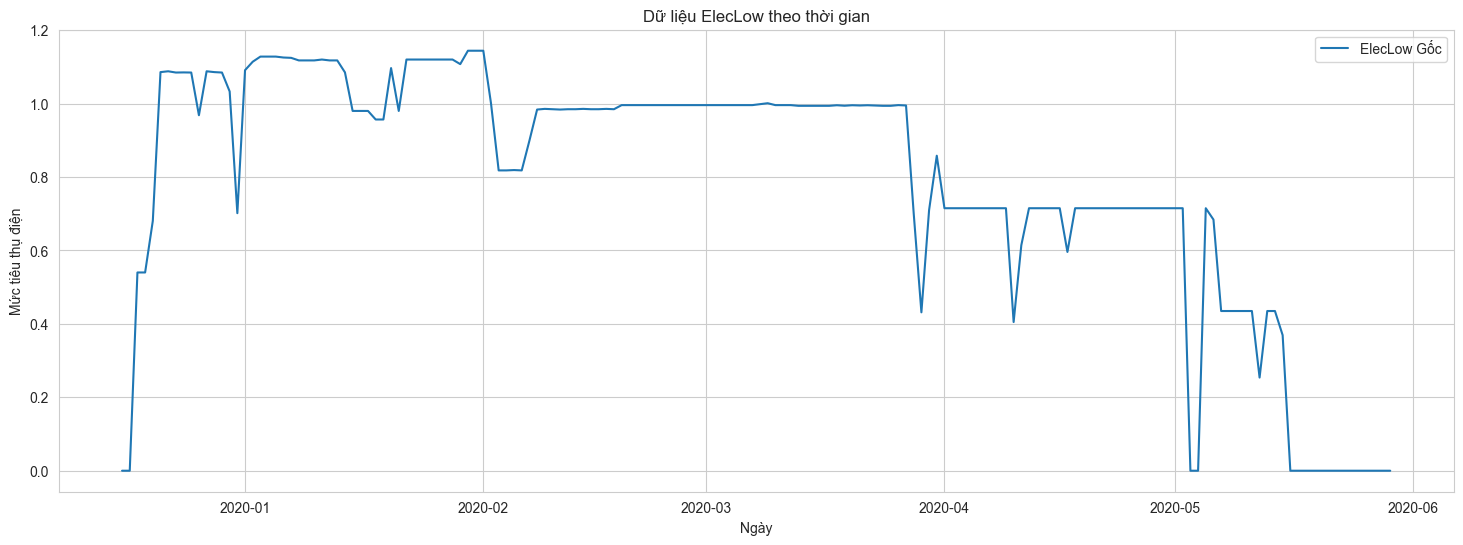


--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---
Tạo đặc trưng hoàn tất.

--- Bước 3: Chạy các mô hình RANDOM FOREST và đánh giá ---

1. Đánh giá Baseline Model (Chỉ Lag Features)...
  -> Kết quả R²: 0.4382

2. Đánh giá Diff Model (Lag + Diff Features)...
  -> Kết quả R²: 0.7988

3. Đánh giá Diff + Time Model (Lag + Diff + Time Features)...
  -> Kết quả R²: 0.7975

--- Bước 4: Trực quan hóa kết quả cuối cùng ---


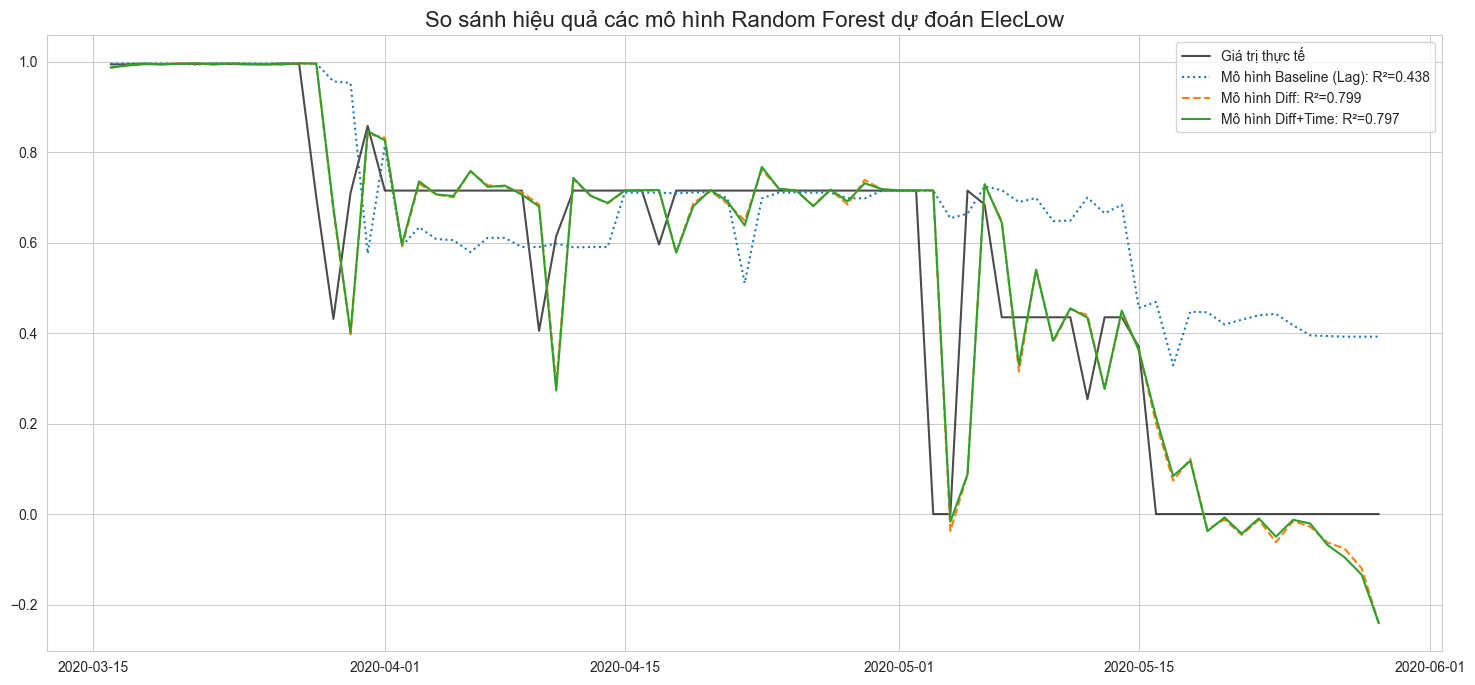


--- Bước 5: Phân tích Feature Importance của mô hình tốt nhất ---
                feature  importance
1    ElecLow_diff_lag_2    0.442928
0    ElecLow_diff_lag_1    0.114121
10  ElecLow_diff_lag_11    0.075908
9   ElecLow_diff_lag_10    0.064152
8    ElecLow_diff_lag_9    0.060504
11  ElecLow_diff_lag_12    0.054779
6    ElecLow_diff_lag_7    0.041452
7    ElecLow_diff_lag_8    0.038941
4    ElecLow_diff_lag_5    0.030386
2    ElecLow_diff_lag_3    0.028156
3    ElecLow_diff_lag_4    0.025727
5    ElecLow_diff_lag_6    0.022946
12             hour_sin    0.000000
13             hour_cos    0.000000


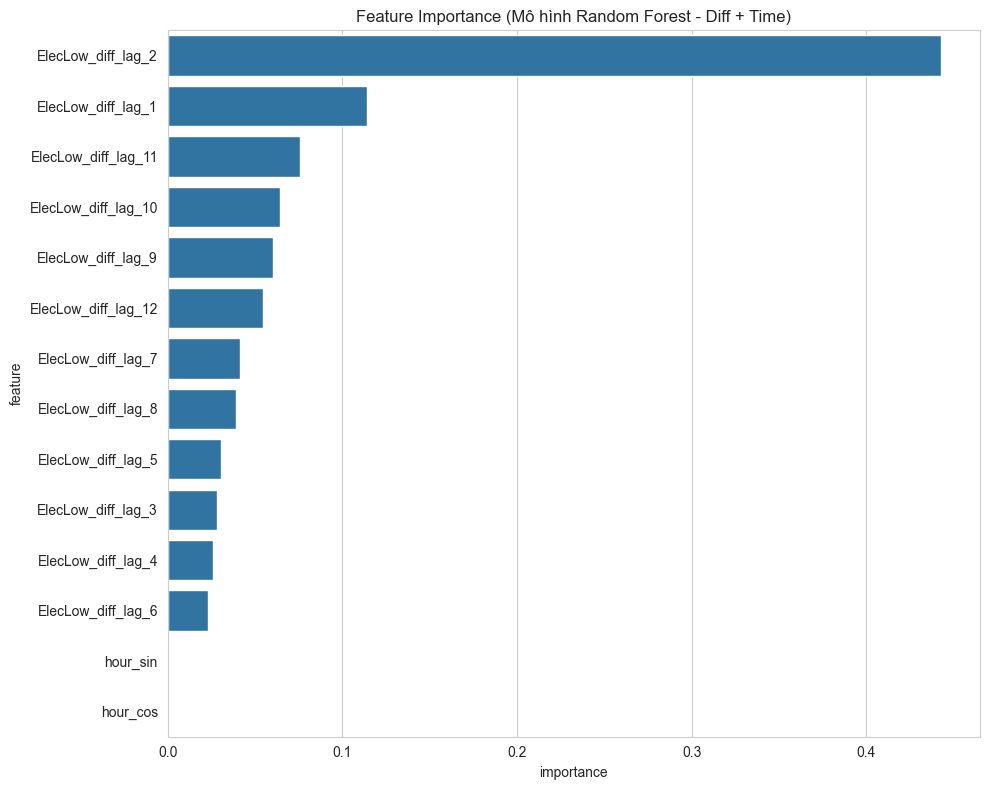

In [79]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
# THAY ĐỔI: Thêm thư viện RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_resources = team_data['Resources.csv'].copy()
time_col = next((col for col in df_resources.columns if col.lower() == 'time'), None)
if time_col:
    df_resources[time_col] = pd.to_numeric(df_resources[time_col], errors='coerce')
    df_resources['datetime'] = pd.to_datetime(df_resources[time_col], unit='D', origin='1899-12-30')
    df_resources.set_index('datetime', inplace=True)
else:
    raise KeyError("Không tìm thấy cột Time.")

data = df_resources[['ElecLow']].copy()
data.ffill(inplace=True)

# 3. TRỰC QUAN HÓA DỮ LIỆU GỐC
# ==============================================================================
print("--- Bước 1: Trực quan hóa dữ liệu ElecLow gốc ---")
plt.figure(figsize=(18, 6))
plt.plot(data['ElecLow'], label='ElecLow Gốc')
plt.title('Dữ liệu ElecLow theo thời gian')
plt.xlabel('Ngày')
plt.ylabel('Mức tiêu thụ điện')
plt.legend()
plt.grid(True)
plt.show()


# 4. TẠO ĐẶC TRƯNG
# ==============================================================================
print("\n--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---")
df_features = data.copy()
NUM_LAGS = 12

# Lag features
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecLow_lag_{i}'] = df_features['ElecLow'].shift(i)

# Differencing features
df_features['ElecLow_diff'] = df_features['ElecLow'].diff(1)
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecLow_diff_lag_{i}'] = df_features['ElecLow_diff'].shift(i)

# Time features
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)

df_features.dropna(inplace=True)
print("Tạo đặc trưng hoàn tất.")


# 5. WALK-FORWARD VALIDATION VỚI RANDOM FOREST
# ==============================================================================
def walk_forward_evaluation(data, features, target, use_diff_target):
    X = data[features]
    y = data[target]
    
    n_splits = 5
    test_size = int(len(X) * 0.1)
    train_size = int(len(X) * 0.4)

    all_preds = []
    all_actuals = []
    final_model = None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)

        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        # THAY ĐỔI CHÍNH: SỬ DỤNG RANDOM FOREST
        # n_jobs=-1 để sử dụng tất cả các nhân CPU, giúp tăng tốc độ huấn luyện
        model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        
        if use_diff_target:
            # Chuyển đổi ngược
            previous_values = data['ElecLow'].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data['ElecLow'].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else:
            preds_recon = preds
            
        actuals = data['ElecLow'].loc[y_test.index]
        
        all_preds.append(preds_recon)
        all_actuals.append(actuals)
        
        if i == n_splits - 1:
            final_model = model

    # Nối kết quả từ tất cả các fold
    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    
    score = r2_score(y_actual_final, y_pred_final)
    
    return {
        'r2': score,
        'predictions': y_pred_final,
        'actuals': y_actual_final,
        'model': final_model,
        'features': features
    }

# --- Chạy 3 mô hình để so sánh ---
print("\n--- Bước 3: Chạy các mô hình RANDOM FOREST và đánh giá ---")

# Model 1: Baseline (Chỉ Lag)
print("\n1. Đánh giá Baseline Model (Chỉ Lag Features)...")
lag_features = [f'ElecLow_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_lag = walk_forward_evaluation(df_features, lag_features, 'ElecLow', use_diff_target=False)
print(f"  -> Kết quả R²: {results_lag['r2']:.4f}")

# Model 2: Diff Model (Lag của dữ liệu sai phân)
print("\n2. Đánh giá Diff Model (Lag + Diff Features)...")
diff_features = [f'ElecLow_diff_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_diff = walk_forward_evaluation(df_features, diff_features, 'ElecLow_diff', use_diff_target=True)
print(f"  -> Kết quả R²: {results_diff['r2']:.4f}")

# Model 3: Diff + Time Model (Mô hình tốt nhất)
print("\n3. Đánh giá Diff + Time Model (Lag + Diff + Time Features)...")
diff_time_features = diff_features + ['hour_sin', 'hour_cos']
results_diff_time = walk_forward_evaluation(df_features, diff_time_features, 'ElecLow_diff', use_diff_target=True)
print(f"  -> Kết quả R²: {results_diff_time['r2']:.4f}")


# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 4: Trực quan hóa kết quả cuối cùng ---")
plt.figure(figsize=(18, 8))
plt.plot(results_diff_time['actuals'], label='Giá trị thực tế', color='black', alpha=0.7)
plt.plot(results_lag['predictions'], label=f"Mô hình Baseline (Lag): R²={results_lag['r2']:.3f}", linestyle=':')
plt.plot(results_diff['predictions'], label=f"Mô hình Diff: R²={results_diff['r2']:.3f}", linestyle='--')
plt.plot(results_diff_time['predictions'], label=f"Mô hình Diff+Time: R²={results_diff_time['r2']:.3f}", linestyle='-')
plt.title('So sánh hiệu quả các mô hình Random Forest dự đoán ElecLow', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Bước 5: Phân tích Feature Importance của mô hình tốt nhất ---")
best_model = results_diff_time['model']
best_features = results_diff_time['features']
if best_model:
    # Đối với RandomForest, feature_importances_ đã có sẵn
    feature_importance = pd.DataFrame({
        'feature': best_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(feature_importance)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance (Mô hình Random Forest - Diff + Time)')
    plt.tight_layout()
    plt.show()

--- Bước 1: Trực quan hóa dữ liệu ElecHigh gốc ---


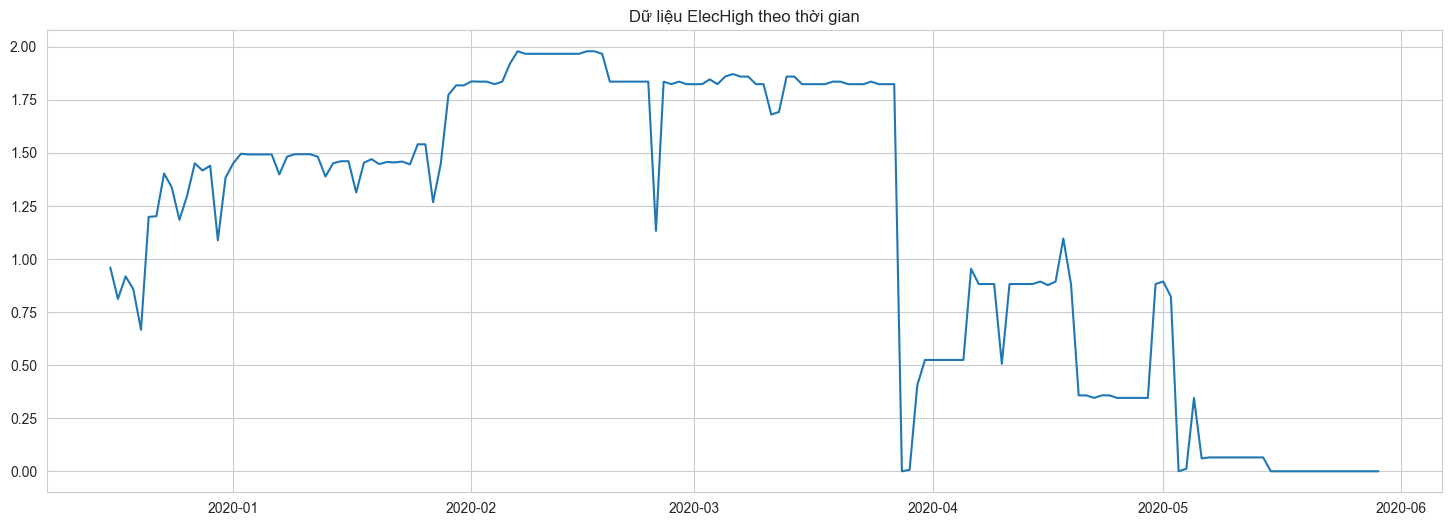


--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---
Tạo đặc trưng hoàn tất.

--- Bước 3: Chạy các mô hình và đánh giá ---

--- Chạy các mô hình RANDOM FOREST ---
  RF Baseline (Lag): R² = 0.3277
  RF Diff Model: R² = 0.7235
  RF Diff+Time Model: R² = 0.7278

--- Chạy các mô hình CATBOOST ---
  CatBoost Baseline (Lag): R² = 0.1948
  CatBoost Diff Model: R² = 0.7703
  CatBoost Diff+Time Model: R² = 0.7703

--- Bước 4: Trực quan hóa so sánh các mô hình tốt nhất ---


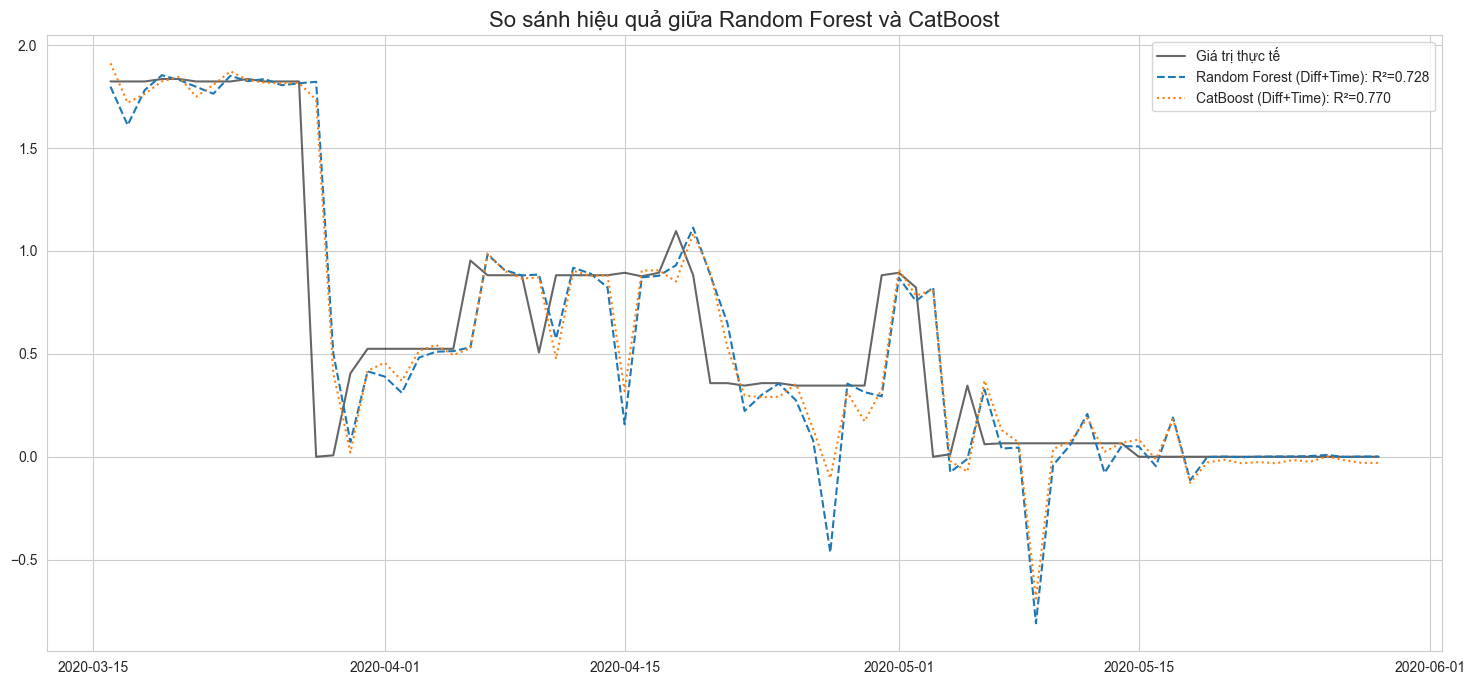


--- Bước 5: Phân tích Feature Importance ---

--- Feature Importance (Random Forest) ---
                 feature  importance
2    ElecHigh_diff_lag_3    0.317102
8    ElecHigh_diff_lag_9    0.195444
1    ElecHigh_diff_lag_2    0.104038
4    ElecHigh_diff_lag_5    0.085050
6    ElecHigh_diff_lag_7    0.073209
11  ElecHigh_diff_lag_12    0.054701
9   ElecHigh_diff_lag_10    0.040755
3    ElecHigh_diff_lag_4    0.039609
7    ElecHigh_diff_lag_8    0.031789
5    ElecHigh_diff_lag_6    0.025209
10  ElecHigh_diff_lag_11    0.016632
0    ElecHigh_diff_lag_1    0.016463
12              hour_sin    0.000000
13              hour_cos    0.000000


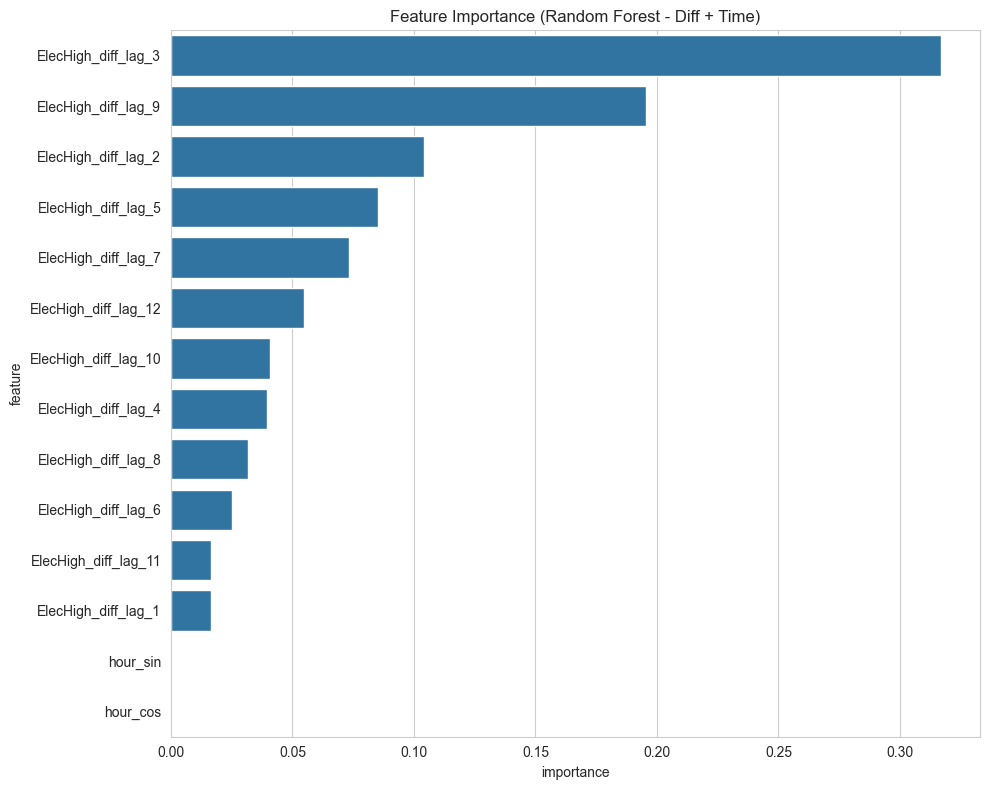


--- Feature Importance (CatBoost) ---
                 feature  importance
2    ElecHigh_diff_lag_3   27.268229
8    ElecHigh_diff_lag_9   19.622456
3    ElecHigh_diff_lag_4   10.951624
11  ElecHigh_diff_lag_12    7.261784
4    ElecHigh_diff_lag_5    6.832558
6    ElecHigh_diff_lag_7    6.646193
1    ElecHigh_diff_lag_2    6.562724
10  ElecHigh_diff_lag_11    3.361269
7    ElecHigh_diff_lag_8    3.126390
5    ElecHigh_diff_lag_6    3.038827
0    ElecHigh_diff_lag_1    2.722889
9   ElecHigh_diff_lag_10    2.605056
12              hour_sin    0.000000
13              hour_cos    0.000000


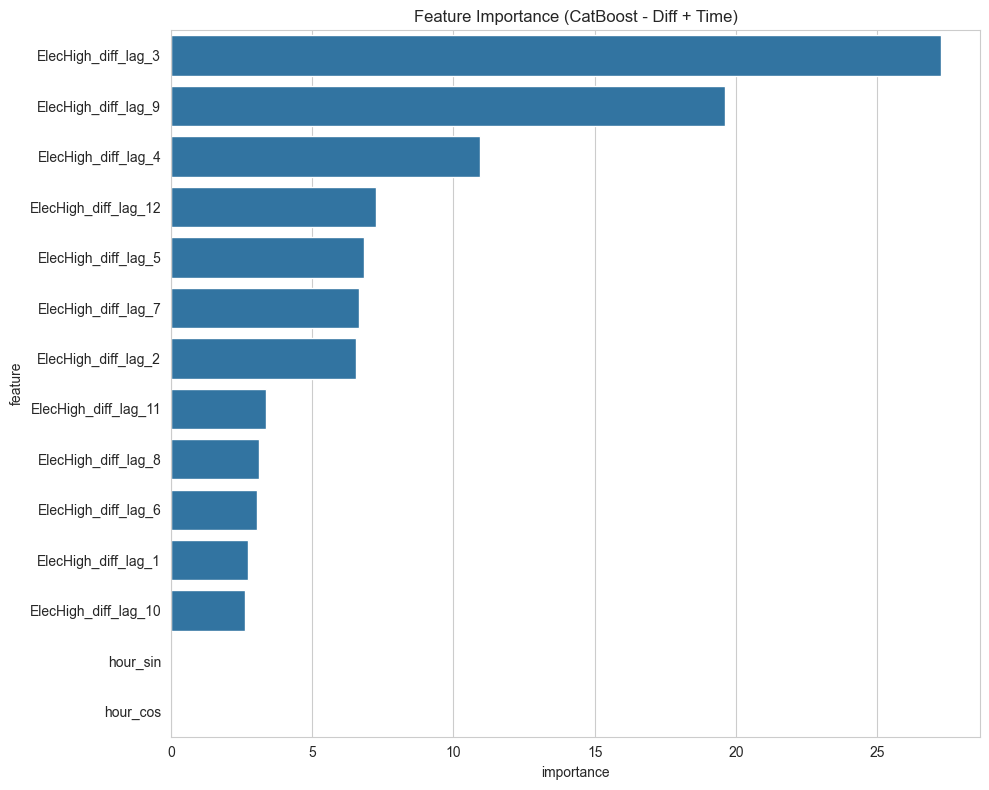

In [83]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# THAY ĐỔI: Thêm thư viện CatBoost
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_resources = team_data['Resources.csv'].copy()
time_col = next((col for col in df_resources.columns if col.lower() == 'time'), None)
if time_col:
    df_resources[time_col] = pd.to_numeric(df_resources[time_col], errors='coerce')
    df_resources['datetime'] = pd.to_datetime(df_resources[time_col], unit='D', origin='1899-12-30')
    df_resources.set_index('datetime', inplace=True)
else:
    raise KeyError("Không tìm thấy cột Time.")

data = df_resources[['ElecHigh']].copy()
data.ffill(inplace=True)

# 3. TRỰC QUAN HÓA DỮ LIỆU GỐC
# ==============================================================================
print("--- Bước 1: Trực quan hóa dữ liệu ElecHigh gốc ---")
plt.figure(figsize=(18, 6))
plt.plot(data['ElecHigh'], label='ElecHigh Gốc')
plt.title('Dữ liệu ElecHigh theo thời gian')
plt.grid(True)
plt.show()


# 4. TẠO ĐẶC TRƯNG
# ==============================================================================
print("\n--- Bước 2: Tạo tất cả các đặc trưng cần thiết ---")
df_features = data.copy()
NUM_LAGS = 12

# Lag, Diff, Time features
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecHigh_lag_{i}'] = df_features['ElecHigh'].shift(i)
df_features['ElecHigh_diff'] = df_features['ElecHigh'].diff(1)
for i in range(1, NUM_LAGS + 1):
    df_features[f'ElecHigh_diff_lag_{i}'] = df_features['ElecHigh_diff'].shift(i)
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features.dropna(inplace=True)
print("Tạo đặc trưng hoàn tất.")


# 5. WALK-FORWARD VALIDATION (Hàm linh hoạt)
# ==============================================================================
def walk_forward_evaluation(data, features, target, use_diff_target, model_name='random_forest'):
    X = data[features]
    y = data[target]
    
    n_splits = 5
    test_size = int(len(X) * 0.1)
    train_size = int(len(X) * 0.4)

    all_preds, all_actuals = [], []
    final_model = None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)

        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        # THAY ĐỔI CHÍNH: CHỌN MÔ HÌNH DỰA TRÊN THAM SỐ
        if model_name == 'random_forest':
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'catboost':
            # verbose=0 để tắt bớt log khi huấn luyện
            model = CatBoostRegressor(random_state=42, verbose=0)
        else:
            raise ValueError("Tên mô hình không được hỗ trợ!")
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        if use_diff_target:
            previous_values = data['ElecHigh'].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data['ElecHigh'].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else:
            preds_recon = preds
            
        actuals = data['ElecHigh'].loc[y_test.index]
        all_preds.append(preds_recon)
        all_actuals.append(actuals)
        
        if i == n_splits - 1: final_model = model

    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    score = r2_score(y_actual_final, y_pred_final)
    
    return {'r2': score, 'predictions': y_pred_final, 'actuals': y_actual_final, 'model': final_model, 'features': features}

# --- Chạy các kịch bản ---
print("\n--- Bước 3: Chạy các mô hình và đánh giá ---")

# --- 3a. RANDOM FOREST ---
print("\n--- Chạy các mô hình RANDOM FOREST ---")
lag_features = [f'ElecHigh_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_rf_lag = walk_forward_evaluation(df_features, lag_features, 'ElecHigh', use_diff_target=False, model_name='random_forest')
print(f"  RF Baseline (Lag): R² = {results_rf_lag['r2']:.4f}")

diff_features = [f'ElecHigh_diff_lag_{i}' for i in range(1, NUM_LAGS + 1)]
results_rf_diff = walk_forward_evaluation(df_features, diff_features, 'ElecHigh_diff', use_diff_target=True, model_name='random_forest')
print(f"  RF Diff Model: R² = {results_rf_diff['r2']:.4f}")

diff_time_features = diff_features + ['hour_sin', 'hour_cos']
results_rf_diff_time = walk_forward_evaluation(df_features, diff_time_features, 'ElecHigh_diff', use_diff_target=True, model_name='random_forest')
print(f"  RF Diff+Time Model: R² = {results_rf_diff_time['r2']:.4f}")

# --- 3b. CATBOOST ---
print("\n--- Chạy các mô hình CATBOOST ---")
results_cb_lag = walk_forward_evaluation(df_features, lag_features, 'ElecHigh', use_diff_target=False, model_name='catboost')
print(f"  CatBoost Baseline (Lag): R² = {results_cb_lag['r2']:.4f}")

results_cb_diff = walk_forward_evaluation(df_features, diff_features, 'ElecHigh_diff', use_diff_target=True, model_name='catboost')
print(f"  CatBoost Diff Model: R² = {results_cb_diff['r2']:.4f}")

results_cb_diff_time = walk_forward_evaluation(df_features, diff_time_features, 'ElecHigh_diff', use_diff_target=True, model_name='catboost')
print(f"  CatBoost Diff+Time Model: R² = {results_cb_diff_time['r2']:.4f}")


# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 4: Trực quan hóa so sánh các mô hình tốt nhất ---")
plt.figure(figsize=(18, 8))
plt.plot(results_rf_diff_time['actuals'], label='Giá trị thực tế', color='black', alpha=0.6)
plt.plot(results_rf_diff_time['predictions'], label=f"Random Forest (Diff+Time): R²={results_rf_diff_time['r2']:.3f}", linestyle='--')
plt.plot(results_cb_diff_time['predictions'], label=f"CatBoost (Diff+Time): R²={results_cb_diff_time['r2']:.3f}", linestyle=':')
plt.title('So sánh hiệu quả giữa Random Forest và CatBoost', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Bước 5: Phân tích Feature Importance ---")

# Random Forest
print("\n--- Feature Importance (Random Forest) ---")
rf_model = results_rf_diff_time['model']
rf_features = results_rf_diff_time['features']
if rf_model:
    rf_importance = pd.DataFrame({'feature': rf_features, 'importance': rf_model.feature_importances_}).sort_values('importance', ascending=False)
    print(rf_importance)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=rf_importance)
    plt.title('Feature Importance (Random Forest - Diff + Time)')
    plt.tight_layout()
    plt.show()

# CatBoost
print("\n--- Feature Importance (CatBoost) ---")
cb_model = results_cb_diff_time['model']
cb_features = results_cb_diff_time['features']
if cb_model:
    cb_importance = pd.DataFrame({'feature': cb_features, 'importance': cb_model.feature_importances_}).sort_values('importance', ascending=False)
    print(cb_importance)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=cb_importance)
    plt.title('Feature Importance (CatBoost - Diff + Time)')
    plt.tight_layout()
    plt.show()

Đã gộp và làm sạch toàn bộ dữ liệu.

--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---
Tạo đặc trưng nâng cao hoàn tất.
Tổng số feature được tạo: 129

--- Bước 3: Định nghĩa các bộ đặc trưng và chạy thử nghiệm ---

--- Đang chạy các mô hình RANDOM_FOREST ---
  Random_forest - Baseline (Lag): R² = 0.4794
  Random_forest - Diff Model: R² = 0.7590
  Random_forest - Full Model (All Features): R² = 0.5947

--- Đang chạy các mô hình CATBOOST ---
  Catboost - Baseline (Lag): R² = 0.1753
  Catboost - Diff Model: R² = 0.7794
  Catboost - Full Model (All Features): R² = 0.7799

--- Bước 4: Trực quan hóa so sánh các mô hình tốt nhất ---


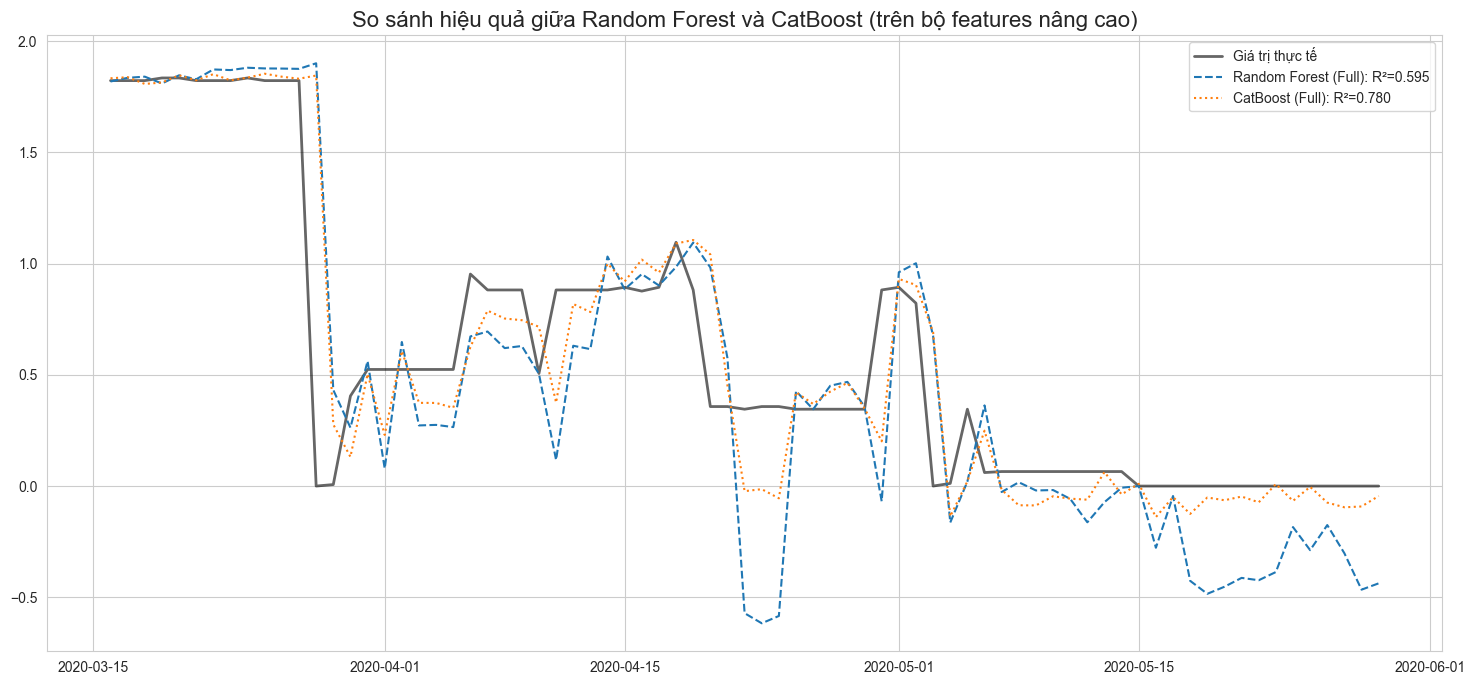


--- Bước 5: Phân tích Feature Importance ---

--- 25 Feature quan trọng nhất (Random Forest) ---
                 feature  importance
102          pH_drain_PC    0.119486
16          CO2air_lag_3    0.082363
73                  Tout    0.075851
58      Rhair_diff_lag_2    0.044751
32               ElecLow    0.040936
22   ElecHigh_diff_lag_3    0.039802
9               CO2_cons    0.038547
15          CO2air_lag_2    0.037370
70            Tair_lag_3    0.036850
57      Rhair_diff_lag_1    0.032899
51        PipeGrow_lag_3    0.030918
62           Rhair_lag_3    0.030703
60           Rhair_lag_1    0.028950
116            water_sup    0.026029
24   ElecHigh_diff_lag_5    0.018235
34             Heat_cons    0.017370
17               Cum_irr    0.016936
48   PipeGrow_diff_lag_3    0.016796
21   ElecHigh_diff_lag_2    0.015751
27        ElecHigh_lag_2    0.015370
47   PipeGrow_diff_lag_2    0.013971
61           Rhair_lag_2    0.011298
52               PipeLow    0.010352
45            

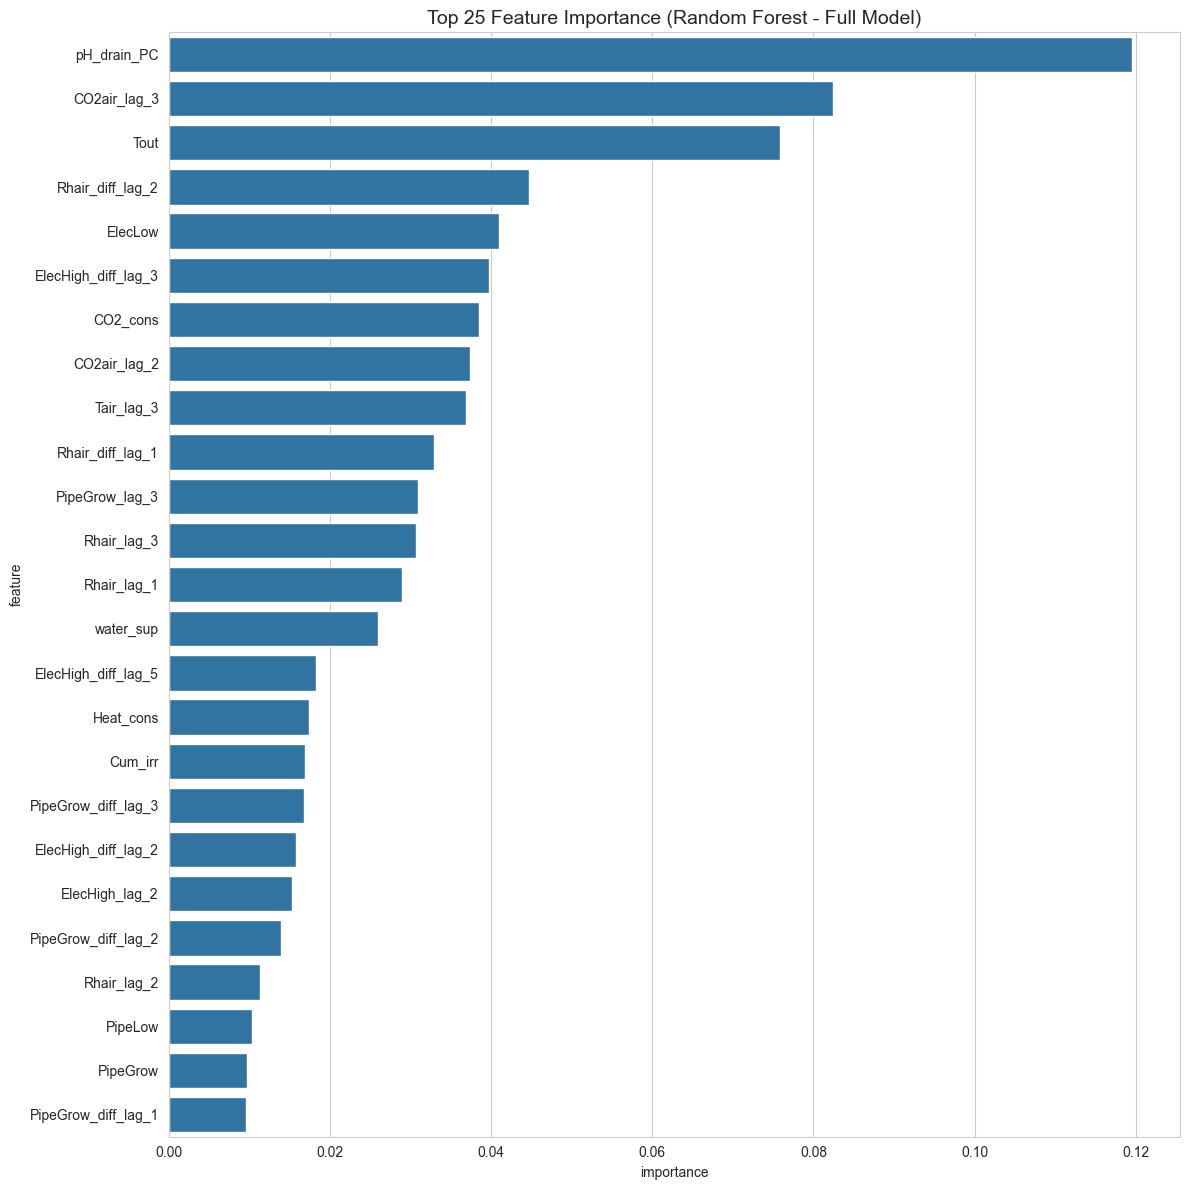


--- 25 Feature quan trọng nhất (CatBoost) ---
                 feature  importance
102          pH_drain_PC    6.612749
16          CO2air_lag_3    6.445266
58      Rhair_diff_lag_2    6.337660
70            Tair_lag_3    5.942763
32               ElecLow    5.893232
57      Rhair_diff_lag_1    3.602429
45              PipeGrow    3.353122
9               CO2_cons    2.635399
61           Rhair_lag_2    2.223001
26        ElecHigh_lag_1    2.176903
116            water_sup    2.054333
59      Rhair_diff_lag_3    2.004086
60           Rhair_lag_1    2.000818
46   PipeGrow_diff_lag_1    1.798572
27        ElecHigh_lag_2    1.752838
21   ElecHigh_diff_lag_2    1.717624
12     CO2air_diff_lag_2    1.680346
22   ElecHigh_diff_lag_3    1.459979
14          CO2air_lag_1    1.456486
20   ElecHigh_diff_lag_1    1.456350
62           Rhair_lag_3    1.445124
17               Cum_irr    1.368435
47   PipeGrow_diff_lag_2    1.342694
63                 Rhout    1.322498
73                  Tout    

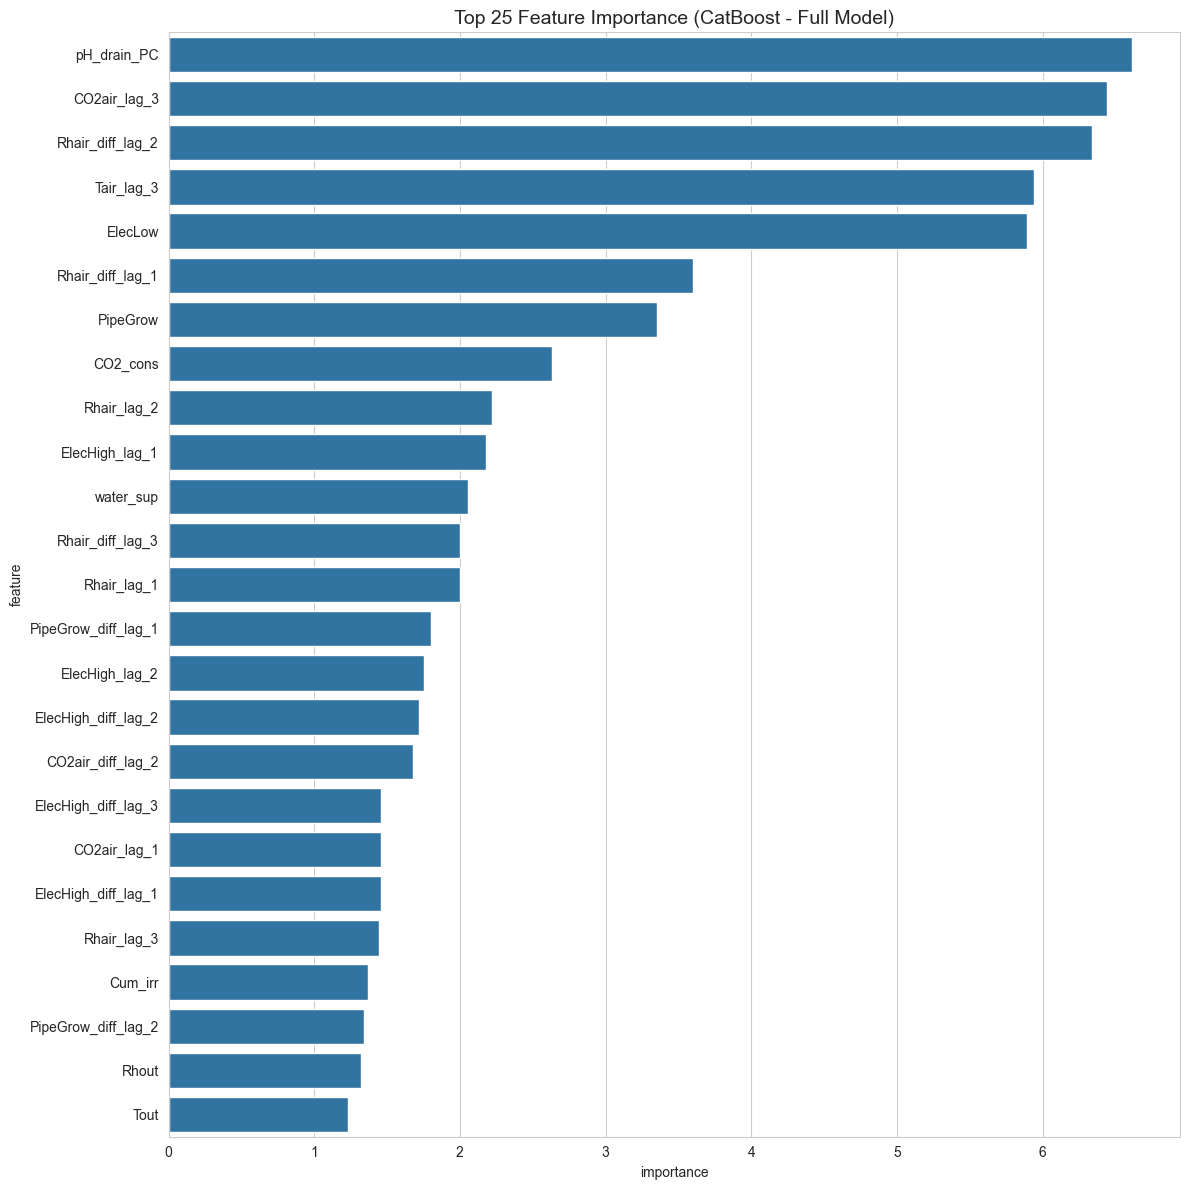

In [89]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

# Gộp tất cả các file lại
df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else:
        raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_full = df_resources.join([df_climate, df_weather], how='inner')
for col in df_full.columns:
    df_full[col] = pd.to_numeric(df_full[col], errors='coerce')

df_full.dropna(axis=1, how='all', inplace=True)
df_full.ffill(inplace=True)
print("Đã gộp và làm sạch toàn bộ dữ liệu.")

# 3. FEATURE ENGINEERING NÂNG CAO
# ==============================================================================
print("\n--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---")
df_features = pd.DataFrame(index=df_full.index)
TARGET = 'ElecHigh'
NUM_LAGS = 6 # Giảm số lag của target để tránh quá nhiều feature

# Giữ lại tất cả các feature gốc
df_features = df_full.copy()

# === THAY ĐỔI LỚN: TẠO LAG VÀ DIFF CHO CÁC FEATURE BÊN NGOÀI ===
# Chọn các feature quan trọng để tạo lag/diff
cols_for_lag_diff = [
    'Tout', 'Tair', 'Iglob', 'Rhair', 'CO2air', 'AssimLight', 'PipeGrow'
]
NUM_EXTERNAL_LAGS = 3 # Chỉ cần 1-3 lag cho các feature bên ngoài là đủ

for col in cols_for_lag_diff:
    if col in df_features.columns:
        # Tạo diff
        df_features[f'{col}_diff'] = df_features[col].diff()
        # Tạo lag cho giá trị gốc và giá trị đã sai phân
        for i in range(1, NUM_EXTERNAL_LAGS + 1):
            df_features[f'{col}_lag_{i}'] = df_features[col].shift(i)
            df_features[f'{col}_diff_lag_{i}'] = df_features[f'{col}_diff'].shift(i)

# Tạo lag và diff cho TARGET
for i in range(1, NUM_LAGS + 1):
    df_features[f'{TARGET}_lag_{i}'] = df_full[TARGET].shift(i)
df_features[f'{TARGET}_diff'] = df_full[TARGET].diff(1)
for i in range(1, NUM_LAGS + 1):
    df_features[f'{TARGET}_diff_lag_{i}'] = df_features[f'{TARGET}_diff'].shift(i)

# Tạo đặc trưng thời gian
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)

# Loại bỏ các cột không cần thiết và xử lý NaN
df_features.drop(columns=[TARGET], inplace=True, errors='ignore')
df_features.dropna(inplace=True)
# Thêm cột target gốc vào để tiện truy vấn
df_features[TARGET] = df_full[TARGET]
print("Tạo đặc trưng nâng cao hoàn tất.")
print(f"Tổng số feature được tạo: {len(df_features.columns) - 1}")


# 4. WALK-FORWARD VALIDATION (Hàm không đổi)
# ==============================================================================
def walk_forward_evaluation(data, features, target, use_diff_target, model_name='random_forest'):
    X = data[features]
    y = data[target]
    
    n_splits = 5
    test_size = int(len(X) * 0.1)
    train_size = int(len(X) * 0.5)
    all_preds, all_actuals, final_model = [], [], None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)

        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        if model_name == 'random_forest':
            model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'catboost':
            model = CatBoostRegressor(random_state=42, verbose=0, allow_writing_files=False)
        else:
            raise ValueError("Tên mô hình không được hỗ trợ!")
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        if use_diff_target:
            previous_values = data[TARGET].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data[TARGET].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else:
            preds_recon = preds
            
        actuals = data[TARGET].loc[y_test.index]
        all_preds.append(preds_recon)
        all_actuals.append(actuals)
        
        if i == n_splits - 1: final_model = model

    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    score = r2_score(y_actual_final, y_pred_final)
    
    return {'r2': score, 'predictions': y_pred_final, 'actuals': y_actual_final, 'model': final_model, 'features': features}

# 5. ĐỊNH NGHĨA CÁC BỘ ĐẶC TRƯNG VÀ CHẠY MÔ HÌNH
# ==============================================================================
print("\n--- Bước 3: Định nghĩa các bộ đặc trưng và chạy thử nghiệm ---")

# Bộ 1: Baseline (Chỉ Lag của target)
features_lag = [f'{TARGET}_lag_{i}' for i in range(1, NUM_LAGS + 1)]

# Bộ 2: Chỉ Lag của target đã sai phân
features_diff = [f'{TARGET}_diff_lag_{i}' for i in range(1, NUM_LAGS + 1)]

# Bộ 3: Bộ đặc trưng đầy đủ nhất
# Lấy tất cả các cột trừ target và các cột trung gian không cần thiết
cols_to_exclude = [TARGET, f'{TARGET}_diff'] + [f'{col}_diff' for col in cols_for_lag_diff]
features_full = [col for col in df_features.columns if col not in cols_to_exclude]
features_full = sorted(list(set(features_full)))

results = {}

for model_name in ['random_forest', 'catboost']:
    print(f"\n--- Đang chạy các mô hình {model_name.upper()} ---")
    
    res_lag = walk_forward_evaluation(df_features, features_lag, TARGET, use_diff_target=False, model_name=model_name)
    results[f'{model_name}_lag'] = res_lag
    print(f"  {model_name.capitalize()} - Baseline (Lag): R² = {res_lag['r2']:.4f}")

    res_diff = walk_forward_evaluation(df_features, features_diff, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    results[f'{model_name}_diff'] = res_diff
    print(f"  {model_name.capitalize()} - Diff Model: R² = {res_diff['r2']:.4f}")
    
    res_full = walk_forward_evaluation(df_features, features_full, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    results[f'{model_name}_full'] = res_full
    print(f"  {model_name.capitalize()} - Full Model (All Features): R² = {res_full['r2']:.4f}")


# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 4: Trực quan hóa so sánh các mô hình tốt nhất ---")
rf_best = results['random_forest_full']
cb_best = results['catboost_full']

plt.figure(figsize=(18, 8))
plt.plot(rf_best['actuals'], label='Giá trị thực tế', color='black', alpha=0.6, linewidth=2)
plt.plot(rf_best['predictions'], label=f"Random Forest (Full): R²={rf_best['r2']:.3f}", linestyle='--')
plt.plot(cb_best['predictions'], label=f"CatBoost (Full): R²={cb_best['r2']:.3f}", linestyle=':')
plt.title('So sánh hiệu quả giữa Random Forest và CatBoost (trên bộ features nâng cao)', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# 7. FEATURE IMPORTANCE CỦA CÁC MÔ HÌNH TỐT NHẤT
# ==============================================================================
print("\n--- Bước 5: Phân tích Feature Importance ---")

def plot_feature_importance(model_results, model_name):
    model = model_results['model']
    features = model_results['features']
    if model:
        importance = pd.DataFrame({
            'feature': features, 
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(25) # Lấy 25 feature quan trọng nhất
        
        print(f"\n--- 25 Feature quan trọng nhất ({model_name}) ---")
        print(importance)
        
        plt.figure(figsize=(12, 12))
        sns.barplot(x='importance', y='feature', data=importance)
        plt.title(f'Top 25 Feature Importance ({model_name} - Full Model)', fontsize=14)
        plt.tight_layout()
        plt.show()

plot_feature_importance(rf_best, 'Random Forest')
plot_feature_importance(cb_best, 'CatBoost')


--- Phân tích Đa cộng tuyến ---


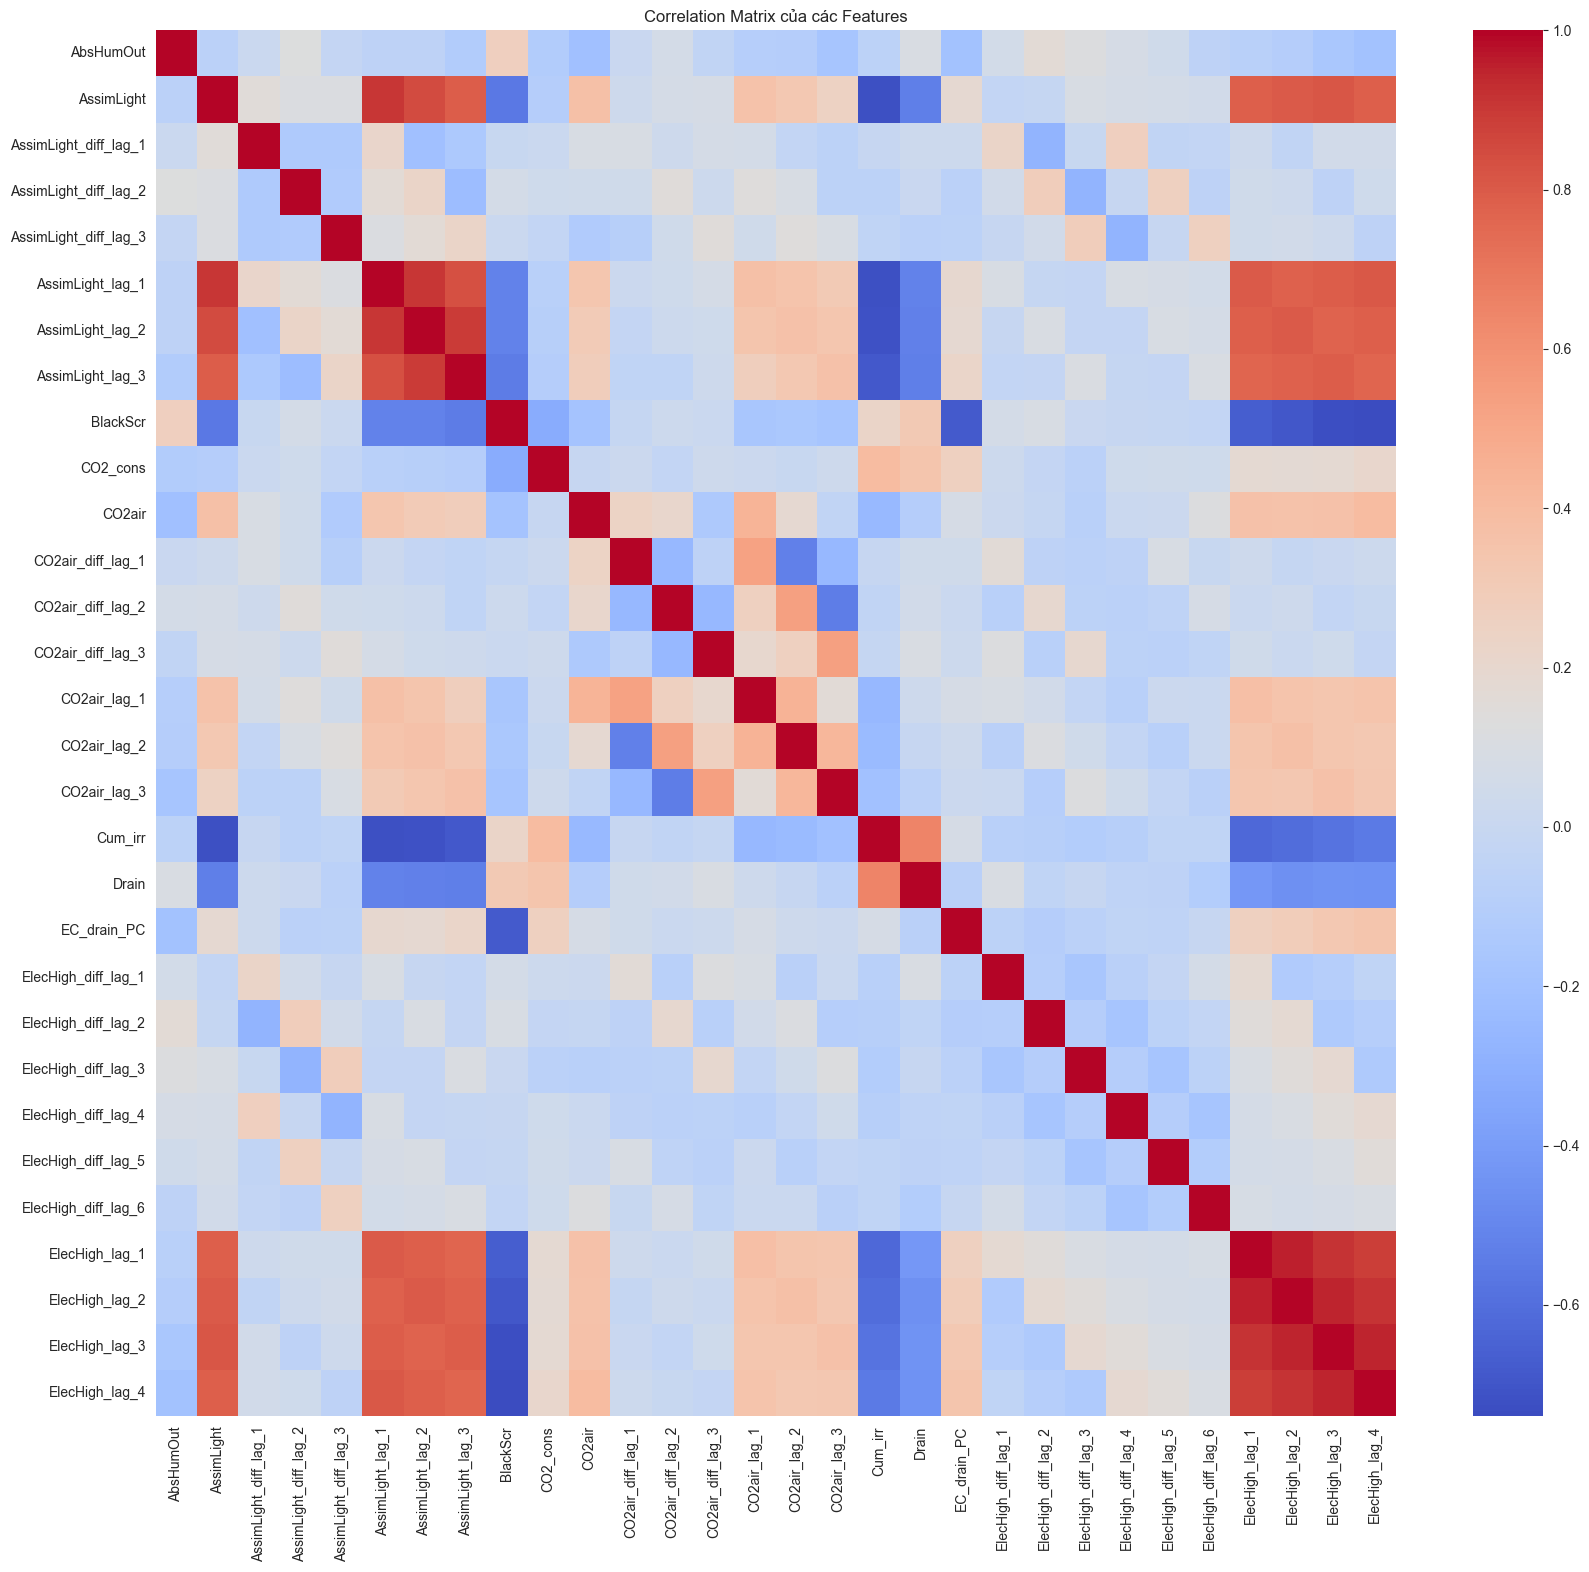

In [90]:
print("\n--- Phân tích Đa cộng tuyến ---")
plt.figure(figsize=(20, 18))
# Chỉ lấy một tập hợp con các feature để heatmap dễ đọc hơn
sample_features = features_full[:30] # Lấy 30 feature đầu tiên
correlation_matrix = df_features[sample_features].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix của các Features')
plt.show()

Đã gộp và làm sạch toàn bộ dữ liệu.

--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---
Tạo đặc trưng nâng cao hoàn tất.

--- Bước 3: Phân tích PCA để xác định số thành phần tối ưu ---


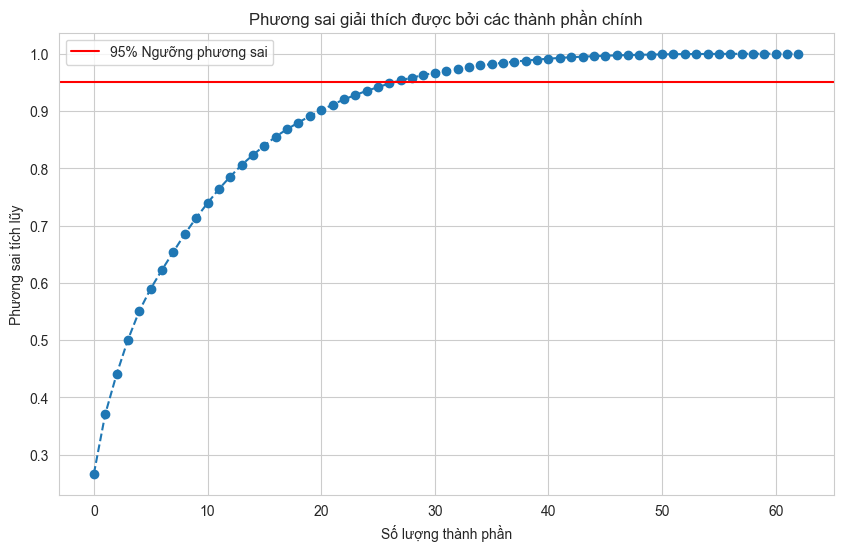

Dựa trên biểu đồ, chúng ta sẽ chọn N_COMPONENTS = 40 để thử nghiệm.

--- Bước 4: Chạy so sánh hiệu quả có và không có PCA ---

1. Đang chạy Full Model (KHÔNG PCA)...
  -> Kết quả R² (Không PCA): 0.6690

2. Đang chạy Full Model (CÓ PCA)...
  -> Kết quả R² (Có PCA): 0.2164

--- Bước 5: Trực quan hóa kết quả so sánh ---


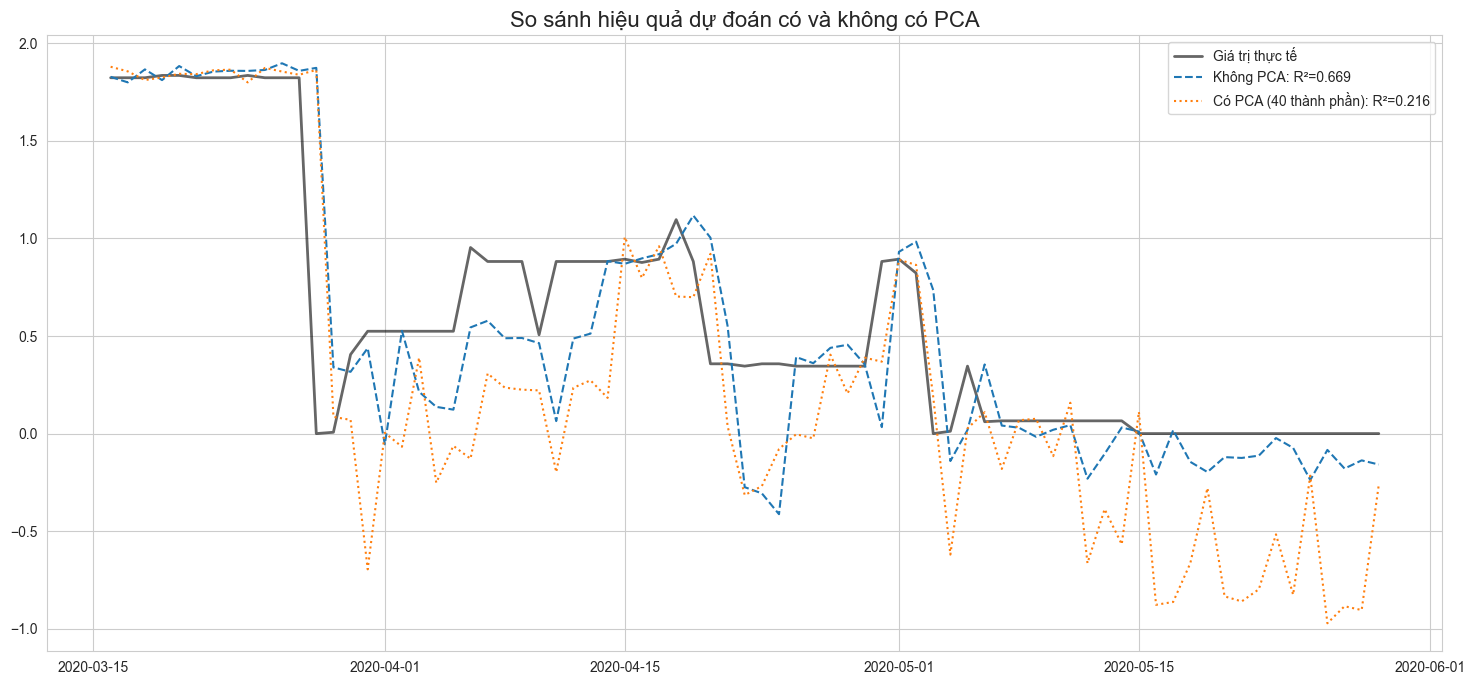


--- Phân tích hoàn tất ---
Lưu ý: Không thể in Feature Importance trực tiếp cho mô hình PCA vì các feature đã bị biến đổi.
Tuy nhiên, kết quả R² đã cho thấy tác động của việc giảm chiều và loại bỏ đa cộng tuyến.


In [104]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
# THAY ĐỔI: Thêm thư viện cho PCA và chuẩn hóa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION (Giữ nguyên)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else: raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_full = df_resources.join([df_climate, df_weather], how='inner')
for col in df_full.columns: df_full[col] = pd.to_numeric(df_full[col], errors='coerce')
df_full.dropna(axis=1, how='all', inplace=True); df_full.ffill(inplace=True)
print("Đã gộp và làm sạch toàn bộ dữ liệu.")

# 3. FEATURE ENGINEERING (Giữ nguyên)
# ==============================================================================
print("\n--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---")
df_features = pd.DataFrame(index=df_full.index)
TARGET = 'ElecHigh'
NUM_LAGS = 6
df_features = df_full.copy()
cols_for_lag_diff = ['Tout', 'Tair', 'Iglob', 'Rhair', 'CO2air', 'AssimLight', 'PipeGrow']
NUM_EXTERNAL_LAGS = 3
for col in cols_for_lag_diff:
    if col in df_features.columns:
        df_features[f'{col}_diff'] = df_features[col].diff()
        for i in range(1, NUM_EXTERNAL_LAGS + 1):
            df_features[f'{col}_lag_{i}'] = df_features[col].shift(i)
            df_features[f'{col}_diff_lag_{i}'] = df_features[f'{col}_diff'].shift(i)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_lag_{i}'] = df_full[TARGET].shift(i)
df_features[f'{TARGET}_diff'] = df_full[TARGET].diff(1)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_diff_lag_{i}'] = df_features[f'{TARGET}_diff'].shift(i)
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features.drop(columns=[TARGET], inplace=True, errors='ignore')
df_features.dropna(inplace=True)
df_features[TARGET] = df_full[TARGET]
print("Tạo đặc trưng nâng cao hoàn tất.")

# 4. PHÂN TÍCH PCA: CẦN BAO NHIÊU THÀNH PHẦN?
# ==============================================================================
print("\n--- Bước 3: Phân tích PCA để xác định số thành phần tối ưu ---")
# Định nghĩa bộ features đầy đủ
cols_to_exclude = [TARGET, f'{TARGET}_diff'] + [f'{col}_diff' for col in cols_for_lag_diff if f'{col}_diff' in df_features.columns]
features_full = [col for col in df_features.columns if col not in cols_to_exclude]
features_full = sorted(list(set(features_full)))

# Chuẩn hóa dữ liệu trước khi chạy PCA
# Chỉ fit trên một phần dữ liệu train để tránh data leakage
temp_train_data = df_features[features_full].iloc[:int(len(df_features)*0.4)]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(temp_train_data)

pca = PCA()
pca.fit(X_scaled)

# Vẽ biểu đồ phương sai tích lũy
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Số lượng thành phần')
plt.ylabel('Phương sai tích lũy')
plt.title('Phương sai giải thích được bởi các thành phần chính')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Ngưỡng phương sai')
plt.legend()
plt.show()

# Dựa vào biểu đồ, chọn số thành phần (ví dụ: 20-30)
N_COMPONENTS =40
print(f"Dựa trên biểu đồ, chúng ta sẽ chọn N_COMPONENTS = {N_COMPONENTS} để thử nghiệm.")

# 5. WALK-FORWARD VALIDATION (Cập nhật để dùng PCA)
# ==============================================================================
def walk_forward_evaluation_pca(data, features, target, use_diff_target, use_pca=False, n_components=20):
    X = data[features]
    y = data[target]
    
    n_splits, test_size, train_size = 5, int(len(X) * 0.1), int(len(X) * 0.4)
    all_preds, all_actuals, final_model = [], [], None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)
        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        # --- TÍCH HỢP PCA VÀO QUY TRÌNH ---
        if use_pca:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            pca_transformer = PCA(n_components=n_components)
            X_train_final = pca_transformer.fit_transform(X_train_scaled)
            X_test_final = pca_transformer.transform(X_test_scaled)
        else:
            X_train_final = X_train
            X_test_final = X_test
        
        model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train_final, y_train)
        preds = model.predict(X_test_final)
        
        if use_diff_target:
            previous_values = data[TARGET].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data[TARGET].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else: preds_recon = preds
        
        actuals = data[TARGET].loc[y_test.index]
        all_preds.append(preds_recon); all_actuals.append(actuals)
        if i == n_splits - 1: final_model = model

    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    score = r2_score(y_actual_final, y_pred_final)
    
    return {'r2': score, 'predictions': y_pred_final, 'actuals': y_actual_final}

# 6. CHẠY SO SÁNH
# ==============================================================================
print("\n--- Bước 4: Chạy so sánh hiệu quả có và không có PCA ---")

# Chạy mô hình Full Features KHÔNG CÓ PCA
print("\n1. Đang chạy Full Model (KHÔNG PCA)...")
results_no_pca = walk_forward_evaluation_pca(
    df_features, features_full, f'{TARGET}_diff', use_diff_target=True, use_pca=False
)
print(f"  -> Kết quả R² (Không PCA): {results_no_pca['r2']:.4f}")

# Chạy mô hình Full Features CÓ PCA
print("\n2. Đang chạy Full Model (CÓ PCA)...")
results_with_pca = walk_forward_evaluation_pca(
    df_features, features_full, f'{TARGET}_diff', use_diff_target=True, use_pca=True, n_components=N_COMPONENTS
)
print(f"  -> Kết quả R² (Có PCA): {results_with_pca['r2']:.4f}")

# 7. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 5: Trực quan hóa kết quả so sánh ---")
plt.figure(figsize=(18, 8))
plt.plot(results_no_pca['actuals'], label='Giá trị thực tế', color='black', alpha=0.6, linewidth=2)
plt.plot(results_no_pca['predictions'], label=f"Không PCA: R²={results_no_pca['r2']:.3f}", linestyle='--')
plt.plot(results_with_pca['predictions'], label=f"Có PCA ({N_COMPONENTS} thành phần): R²={results_with_pca['r2']:.3f}", linestyle=':')
plt.title('So sánh hiệu quả dự đoán có và không có PCA', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Phân tích hoàn tất ---")
print("Lưu ý: Không thể in Feature Importance trực tiếp cho mô hình PCA vì các feature đã bị biến đổi.")
print("Tuy nhiên, kết quả R² đã cho thấy tác động của việc giảm chiều và loại bỏ đa cộng tuyến.")

Đã gộp và làm sạch toàn bộ dữ liệu.

--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---
Tạo đặc trưng nâng cao hoàn tất.

--- Bước 3: Chạy quy trình phân tích đầy đủ với Feature Selection ---

==================== BẮT ĐẦU PHÂN TÍCH CHO RANDOM_FOREST ====================

--- Đang chạy RANDOM_FOREST với Full Features (để lấy importance)...

--- Thực hiện Feature Selection cho RANDOM_FOREST ---
Đã chọn ra 25 feature quan trọng nhất.

--- Đang chạy lại RANDOM_FOREST với 25 feature đã chọn...

--- KẾT QUẢ TÓM TẮT ---
  Random_forest - Baseline (Lag): R² = 0.4588
  Random_forest - Diff Model: R² = 0.7687
  Random_forest - Full Model: R² = 0.6690
  Random_forest - Selected Features Model: R² = 0.7665 <--- KẾT QUẢ QUAN TRỌNG

==================== BẮT ĐẦU PHÂN TÍCH CHO CATBOOST ====================

--- Đang chạy CATBOOST với Full Features (để lấy importance)...

--- Thực hiện Feature Selection cho CATBOOST ---
Đã chọn ra 25 feature quan trọng nhất.

--- Đang chạy lại CATBOOST với 25 feature đã

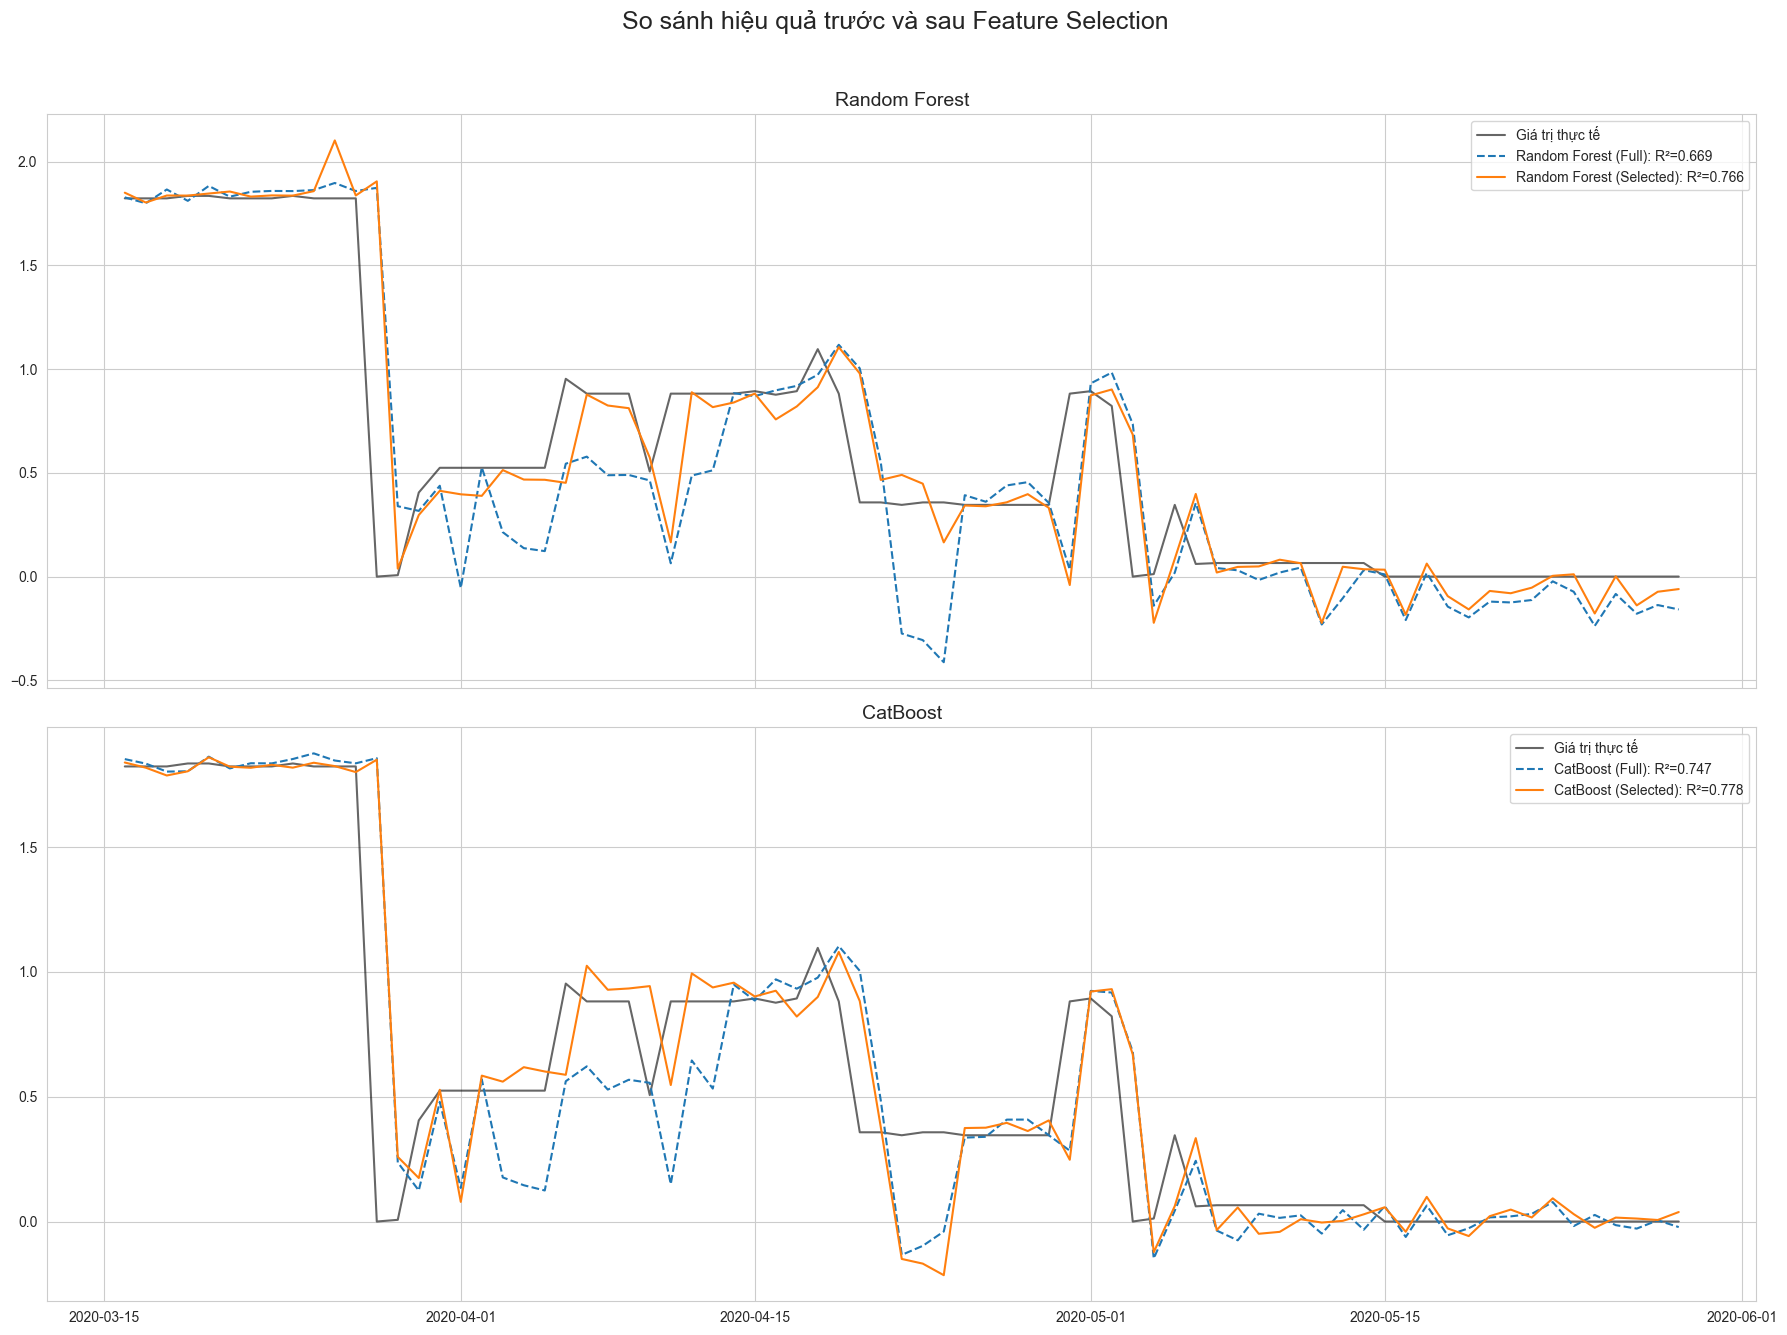


--- Bước 5: Phân tích Feature Importance (dùng để chọn features) ---

--- Top 25 Feature quan trọng nhất (Random Forest) ---
                 feature  importance
70            Tair_lag_3    0.257991
16          CO2air_lag_3    0.073160
22   ElecHigh_diff_lag_3    0.060183
62           Rhair_lag_3    0.053407
60           Rhair_lag_1    0.043814
32               ElecLow    0.037522
15          CO2air_lag_2    0.031753
116            water_sup    0.028544
48   PipeGrow_diff_lag_3    0.028265
102          pH_drain_PC    0.027820
24   ElecHigh_diff_lag_5    0.026845
9               CO2_cons    0.026787
21   ElecHigh_diff_lag_2    0.024140
51        PipeGrow_lag_3    0.023490
17               Cum_irr    0.022807
58      Rhair_diff_lag_2    0.020923
27        ElecHigh_lag_2    0.016832
69            Tair_lag_2    0.012237
10                CO2air    0.011089
46   PipeGrow_diff_lag_1    0.011007
23   ElecHigh_diff_lag_4    0.010600
25   ElecHigh_diff_lag_6    0.009929
56                 Rhai

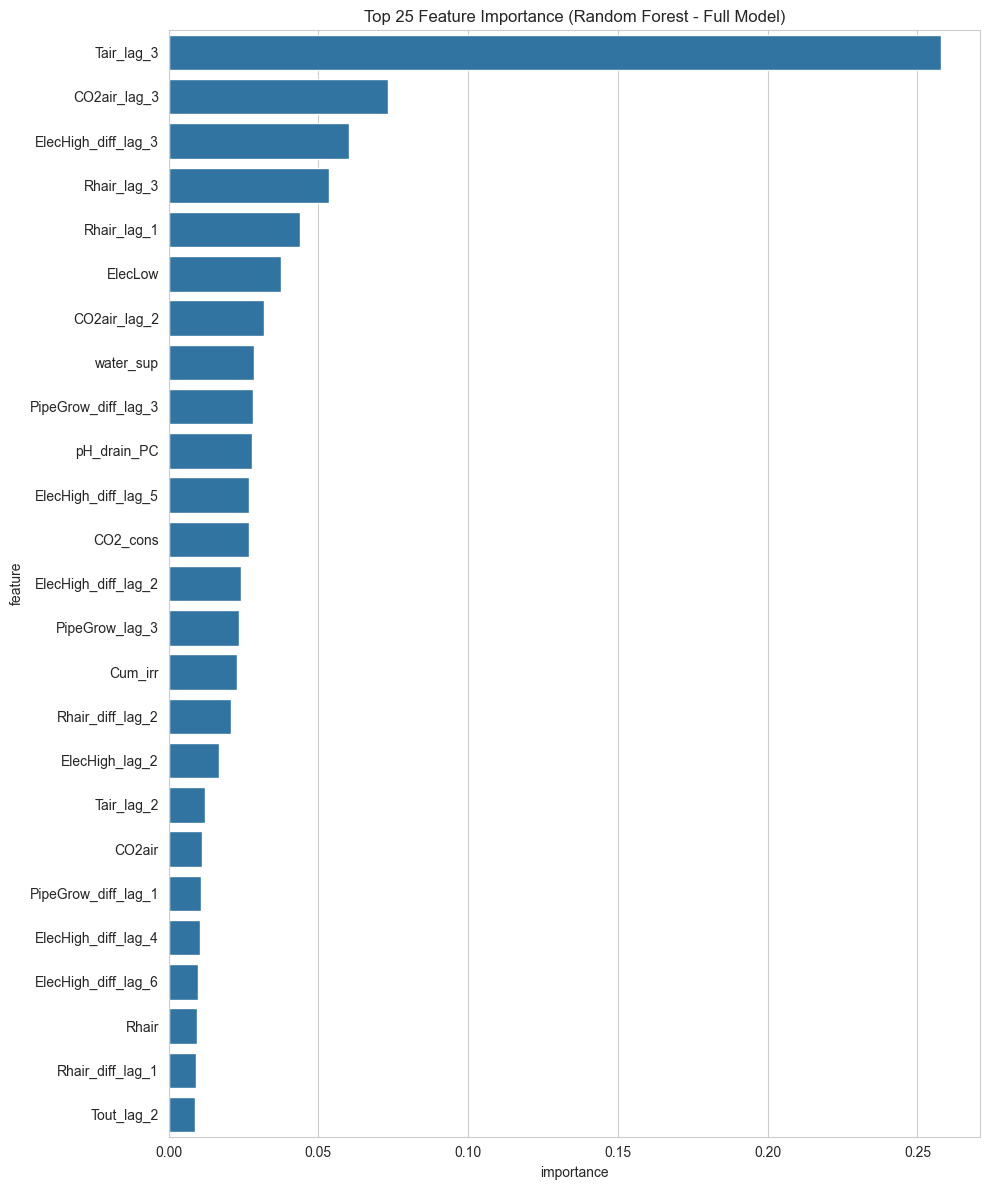


--- Top 25 Feature quan trọng nhất (CatBoost) ---
                 feature  importance
70            Tair_lag_3   30.859005
16          CO2air_lag_3    3.952766
22   ElecHigh_diff_lag_3    3.823436
9               CO2_cons    2.487080
27        ElecHigh_lag_2    2.174008
21   ElecHigh_diff_lag_2    2.162905
60           Rhair_lag_1    2.082336
59      Rhair_diff_lag_3    2.041615
32               ElecLow    1.943781
47   PipeGrow_diff_lag_2    1.887590
102          pH_drain_PC    1.767538
45              PipeGrow    1.630633
17               Cum_irr    1.601413
116            water_sup    1.594978
24   ElecHigh_diff_lag_5    1.546641
66       Tair_diff_lag_2    1.532300
51        PipeGrow_lag_3    1.507859
26        ElecHigh_lag_1    1.501404
61           Rhair_lag_2    1.342679
57      Rhair_diff_lag_1    1.288056
34             Heat_cons    1.261790
62           Rhair_lag_3    1.170101
73                  Tout    1.114008
65       Tair_diff_lag_1    1.096104
48   PipeGrow_diff_lag_3

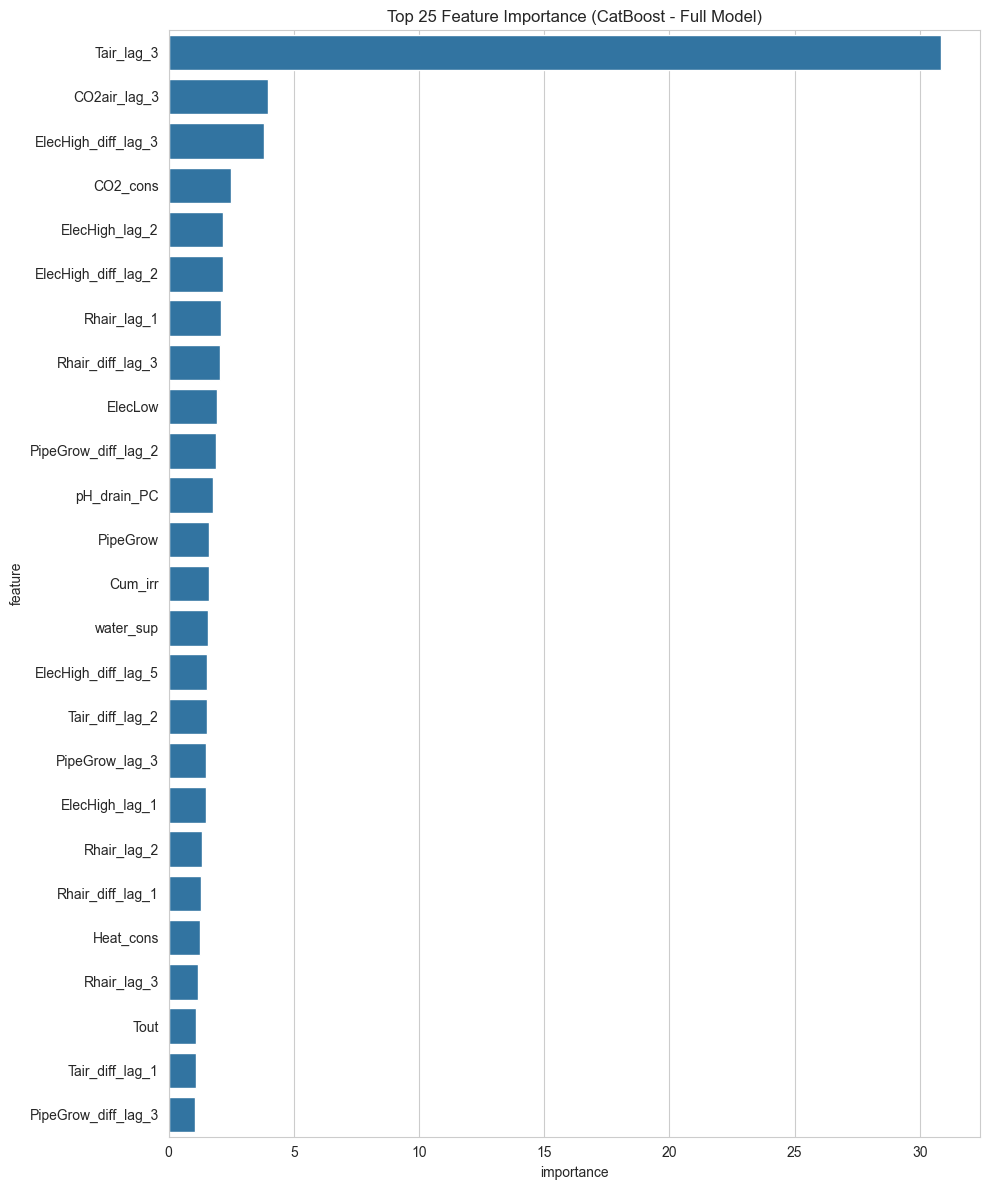

In [108]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION (Giữ nguyên)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else: raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_full = df_resources.join([df_climate, df_weather], how='inner')
for col in df_full.columns: df_full[col] = pd.to_numeric(df_full[col], errors='coerce')
df_full.dropna(axis=1, how='all', inplace=True); df_full.ffill(inplace=True)
print("Đã gộp và làm sạch toàn bộ dữ liệu.")

# 3. FEATURE ENGINEERING (Giữ nguyên)
# ==============================================================================
print("\n--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---")
df_features = pd.DataFrame(index=df_full.index)
TARGET = 'ElecHigh'
NUM_LAGS = 6
df_features = df_full.copy()
cols_for_lag_diff = ['Tout', 'Tair', 'Iglob', 'Rhair', 'CO2air', 'AssimLight', 'PipeGrow']
NUM_EXTERNAL_LAGS = 3
for col in cols_for_lag_diff:
    if col in df_features.columns:
        df_features[f'{col}_diff'] = df_features[col].diff()
        for i in range(1, NUM_EXTERNAL_LAGS + 1):
            df_features[f'{col}_lag_{i}'] = df_features[col].shift(i)
            df_features[f'{col}_diff_lag_{i}'] = df_features[f'{col}_diff'].shift(i)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_lag_{i}'] = df_full[TARGET].shift(i)
df_features[f'{TARGET}_diff'] = df_full[TARGET].diff(1)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_diff_lag_{i}'] = df_features[f'{TARGET}_diff'].shift(i)
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features.drop(columns=[TARGET], inplace=True, errors='ignore')
df_features.dropna(inplace=True)
df_features[TARGET] = df_full[TARGET]
print("Tạo đặc trưng nâng cao hoàn tất.")

# 4. WALK-FORWARD VALIDATION (Hàm không đổi)
# ==============================================================================
def walk_forward_evaluation(data, features, target, use_diff_target, model_name='random_forest'):
    X = data[features]
    y = data[target]
    
    n_splits, test_size, train_size = 5, int(len(X) * 0.1), int(len(X) * 0.4)
    all_preds, all_actuals, final_model = [], [], None

    for i in range(n_splits):
        test_end_index = len(X) - (n_splits - 1 - i) * test_size
        test_start_index = test_end_index - test_size
        train_end_index = test_start_index
        train_start_index = max(0, train_end_index - train_size)
        X_train, X_test = X.iloc[train_start_index:train_end_index], X.iloc[test_start_index:test_end_index]
        y_train, y_test = y.iloc[train_start_index:train_end_index], y.iloc[test_start_index:test_end_index]

        if len(X_train) == 0: continue

        if model_name == 'random_forest': model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'catboost': model = CatBoostRegressor(random_state=42, verbose=0, allow_writing_files=False)
        else: raise ValueError("Tên mô hình không được hỗ trợ!")
        
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        if use_diff_target:
            previous_values = data[TARGET].loc[y_test.index].shift(1)
            previous_values.iloc[0] = data[TARGET].iloc[X.index.get_loc(y_test.index[0]) - 1]
            preds_recon = previous_values + preds
        else: preds_recon = preds
        
        actuals = data[TARGET].loc[y_test.index]
        all_preds.append(preds_recon); all_actuals.append(actuals)
        if i == n_splits - 1: final_model = model

    y_pred_final = pd.concat([pd.Series(p, index=a.index) for p, a in zip(all_preds, all_actuals)])
    y_actual_final = pd.concat(all_actuals)
    score = r2_score(y_actual_final, y_pred_final)
    
    return {'r2': score, 'predictions': y_pred_final, 'actuals': y_actual_final, 'model': final_model, 'features': features}

# 5. QUY TRÌNH PHÂN TÍCH VỚI FEATURE SELECTION
# ==============================================================================
print("\n--- Bước 3: Chạy quy trình phân tích đầy đủ với Feature Selection ---")

# Định nghĩa các bộ features ban đầu
features_lag = [f'{TARGET}_lag_{i}' for i in range(1, NUM_LAGS + 1)]
features_diff = [f'{TARGET}_diff_lag_{i}' for i in range(1, NUM_LAGS + 1)]
cols_to_exclude = [TARGET, f'{TARGET}_diff'] + [f'{col}_diff' for col in cols_for_lag_diff if f'{col}_diff' in df_features.columns]
features_full = [col for col in df_features.columns if col not in cols_to_exclude]
features_full = sorted(list(set(features_full)))

all_results = {}
N_TOP_FEATURES = 25 # Chọn top 30 features

for model_name in ['random_forest', 'catboost']:
    print(f"\n{'='*20} BẮT ĐẦU PHÂN TÍCH CHO {model_name.upper()} {'='*20}")
    
    # Kịch bản 1: Baseline
    res_lag = walk_forward_evaluation(df_features, features_lag, TARGET, use_diff_target=False, model_name=model_name)
    all_results[f'{model_name}_lag'] = res_lag
    
    # Kịch bản 2: Diff
    res_diff = walk_forward_evaluation(df_features, features_diff, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    all_results[f'{model_name}_diff'] = res_diff
    
    # Kịch bản 3: Full Features (để lấy importance)
    print(f"\n--- Đang chạy {model_name.upper()} với Full Features (để lấy importance)...")
    res_full = walk_forward_evaluation(df_features, features_full, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    all_results[f'{model_name}_full'] = res_full

    # Bước Feature Selection
    print(f"\n--- Thực hiện Feature Selection cho {model_name.upper()} ---")
    model_for_selection = res_full['model']
    importance = pd.DataFrame({
        'feature': res_full['features'], 
        'importance': model_for_selection.feature_importances_
    }).sort_values('importance', ascending=False)
    
    selected_features = importance.head(N_TOP_FEATURES)['feature'].tolist()
    print(f"Đã chọn ra {N_TOP_FEATURES} feature quan trọng nhất.")
    # print(selected_features) # Bỏ comment nếu muốn xem danh sách features
    
    # Kịch bản 4: Chạy lại mô hình chỉ với các feature đã chọn
    print(f"\n--- Đang chạy lại {model_name.upper()} với {N_TOP_FEATURES} feature đã chọn...")
    res_selected = walk_forward_evaluation(df_features, selected_features, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    all_results[f'{model_name}_selected'] = res_selected
    
    # In kết quả tóm tắt cho mô hình này
    print("\n--- KẾT QUẢ TÓM TẮT ---")
    print(f"  {model_name.capitalize()} - Baseline (Lag): R² = {res_lag['r2']:.4f}")
    print(f"  {model_name.capitalize()} - Diff Model: R² = {res_diff['r2']:.4f}")
    print(f"  {model_name.capitalize()} - Full Model: R² = {res_full['r2']:.4f}")
    print(f"  {model_name.capitalize()} - Selected Features Model: R² = {res_selected['r2']:.4f} <--- KẾT QUẢ QUAN TRỌNG")

# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n--- Bước 4: Trực quan hóa so sánh các mô hình tốt nhất ---")
rf_full = all_results['random_forest_full']
rf_selected = all_results['random_forest_selected']
cb_full = all_results['catboost_full']
cb_selected = all_results['catboost_selected']

fig, axes = plt.subplots(2, 1, figsize=(18, 14), sharex=True)
fig.suptitle('So sánh hiệu quả trước và sau Feature Selection', fontsize=18)

# Biểu đồ cho Random Forest
axes[0].plot(rf_full['actuals'], label='Giá trị thực tế', color='black', alpha=0.6)
axes[0].plot(rf_full['predictions'], label=f"Random Forest (Full): R²={rf_full['r2']:.3f}", linestyle='--')
axes[0].plot(rf_selected['predictions'], label=f"Random Forest (Selected): R²={rf_selected['r2']:.3f}", linestyle='-')
axes[0].set_title('Random Forest', fontsize=14)
axes[0].legend()
axes[0].grid(True)

# Biểu đồ cho CatBoost
axes[1].plot(cb_full['actuals'], label='Giá trị thực tế', color='black', alpha=0.6)
axes[1].plot(cb_full['predictions'], label=f"CatBoost (Full): R²={cb_full['r2']:.3f}", linestyle='--')
axes[1].plot(cb_selected['predictions'], label=f"CatBoost (Selected): R²={cb_selected['r2']:.3f}", linestyle='-')
axes[1].set_title('CatBoost', fontsize=14)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# 7. FEATURE IMPORTANCE CỦA CÁC MÔ HÌNH FULL (ĐỂ XEM FEATURE NÀO ĐƯỢC CHỌN)
# ==============================================================================
print("\n--- Bước 5: Phân tích Feature Importance (dùng để chọn features) ---")
def plot_feature_importance(model_results, model_name):
    importance = pd.DataFrame({
        'feature': model_results['features'], 
        'importance': model_results['model'].feature_importances_
    }).sort_values('importance', ascending=False).head(N_TOP_FEATURES)
    print(f"\n--- Top {N_TOP_FEATURES} Feature quan trọng nhất ({model_name}) ---")
    print(importance)
    plt.figure(figsize=(10, 12)); sns.barplot(x='importance', y='feature', data=importance)
    plt.title(f'Top {N_TOP_FEATURES} Feature Importance ({model_name} - Full Model)'); plt.tight_layout(); plt.show()

plot_feature_importance(all_results['random_forest_full'], 'Random Forest')
plot_feature_importance(all_results['catboost_full'], 'CatBoost')

Đã gộp và làm sạch toàn bộ dữ liệu.

--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---
Tạo đặc trưng nâng cao hoàn tất.

--- Bước 3: Bắt đầu cuộc thi giữa các mô hình ---
--- Đang chạy mô hình CatBoost trên Full Features để chọn features ---
--- Đã chọn ra 25 feature quan trọng nhất từ CatBoost ---

--- Đang huấn luyện RANDOM_FOREST với Selected Features ---

--- Đang huấn luyện CATBOOST với Selected Features ---

--- Đang huấn luyện XGBOOST với Selected Features ---

--- Đang huấn luyện ARIMA ---

--- Đang huấn luyện PROPHET ---


--- Bước 4: TỔNG KẾT KẾT QUẢ CUỐI CÙNG ---
                    Model  R2_Score
0       Catboost Selected  0.778133
1  Random Forest Selected  0.693997
2                 Prophet  0.520770
3                   Arima  0.518997
4        Xgboost Selected  0.299269

--- Bước 5: Trực quan hóa so sánh các mô hình hàng đầu ---


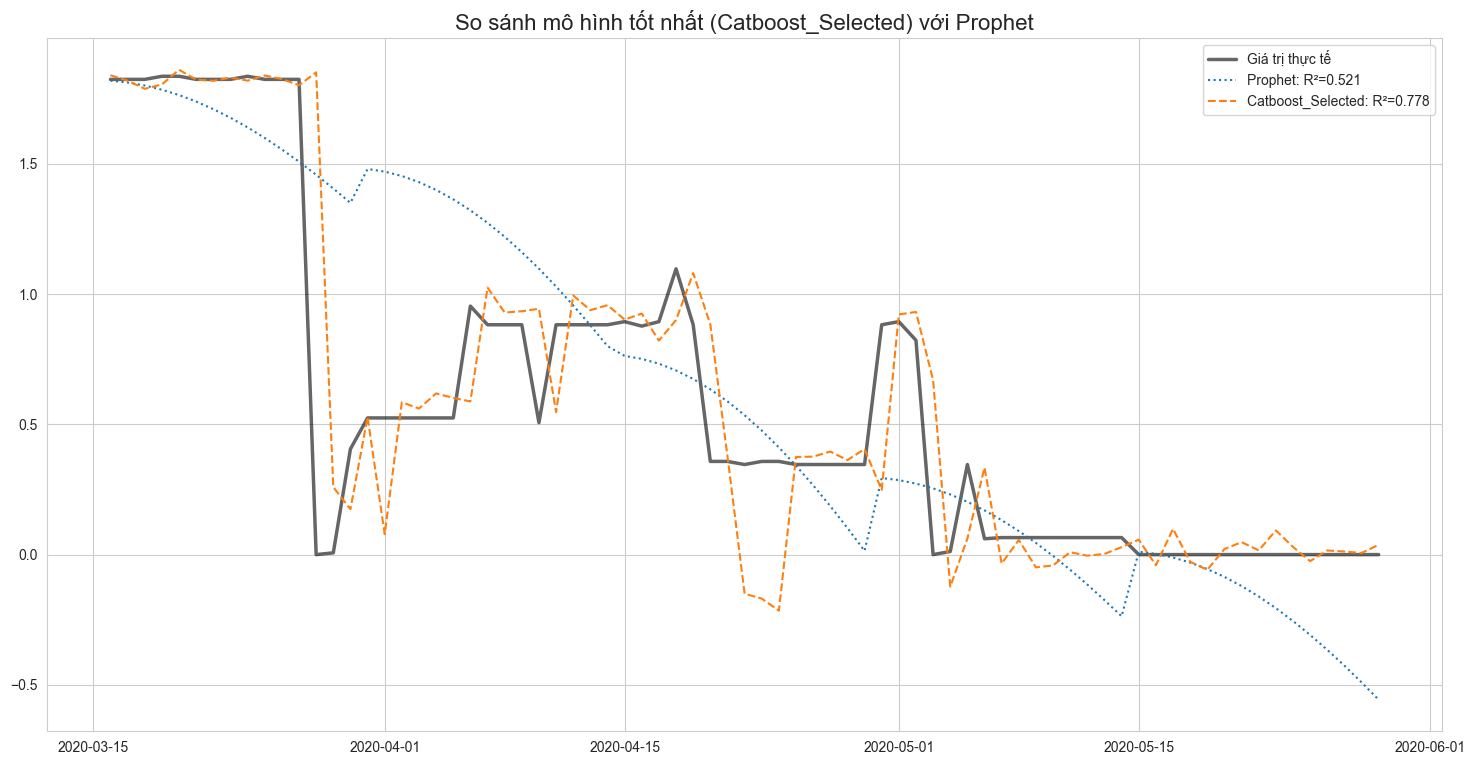


--- Bước 6: Phân tích Top 25 Feature đã được chọn ---
                 feature  importance
70            Tair_lag_3   30.859005
16          CO2air_lag_3    3.952766
22   ElecHigh_diff_lag_3    3.823436
9               CO2_cons    2.487080
27        ElecHigh_lag_2    2.174008
21   ElecHigh_diff_lag_2    2.162905
60           Rhair_lag_1    2.082336
59      Rhair_diff_lag_3    2.041615
32               ElecLow    1.943781
47   PipeGrow_diff_lag_2    1.887590
102          pH_drain_PC    1.767538
45              PipeGrow    1.630633
17               Cum_irr    1.601413
116            water_sup    1.594978
24   ElecHigh_diff_lag_5    1.546641
66       Tair_diff_lag_2    1.532300
51        PipeGrow_lag_3    1.507859
26        ElecHigh_lag_1    1.501404
61           Rhair_lag_2    1.342679
57      Rhair_diff_lag_1    1.288056
34             Heat_cons    1.261790
62           Rhair_lag_3    1.170101
73                  Tout    1.114008
65       Tair_diff_lag_1    1.096104
48   PipeGrow_diff_l

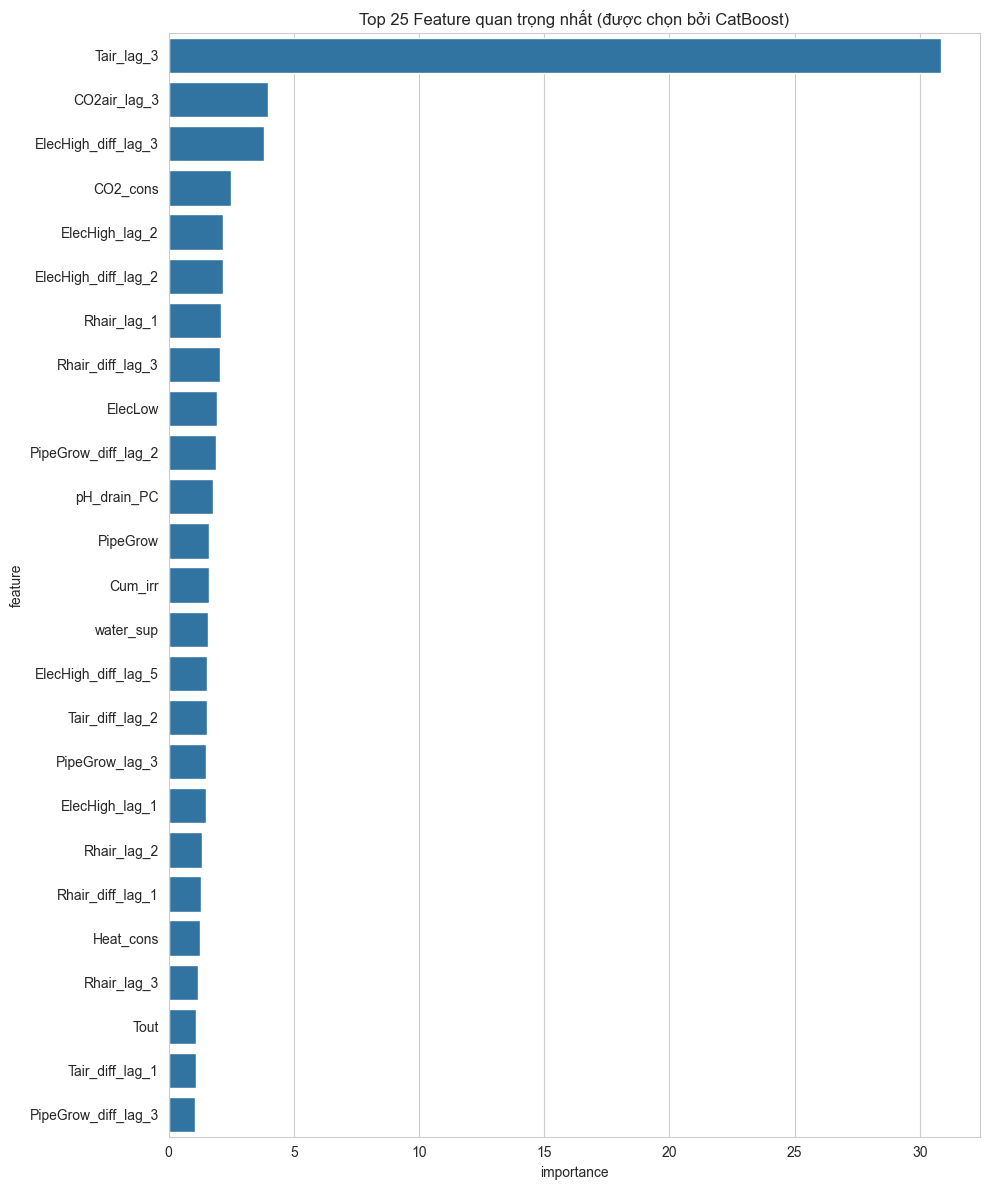

In [116]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import warnings

warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# 2. DATA LOADING & PREPARATION (Giữ nguyên)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Thư mục không tồn tại: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else: raise KeyError(f"LỖI: Không tìm thấy cột 'Time' trong {name}.csv")

df_full = df_resources.join([df_climate, df_weather], how='inner')
for col in df_full.columns: df_full[col] = pd.to_numeric(df_full[col], errors='coerce')
df_full.dropna(axis=1, how='all', inplace=True); df_full.ffill(inplace=True)
print("Đã gộp và làm sạch toàn bộ dữ liệu.")

# 3. FEATURE ENGINEERING (Giữ nguyên)
# ==============================================================================
print("\n--- Bước 2: Tạo bộ dữ liệu đặc trưng nâng cao ---")
df_features = pd.DataFrame(index=df_full.index)
TARGET = 'ElecHigh'
NUM_LAGS = 6
df_features = df_full.copy()
cols_for_lag_diff = ['Tout', 'Tair', 'Iglob', 'Rhair', 'CO2air', 'AssimLight', 'PipeGrow']
NUM_EXTERNAL_LAGS = 3
for col in cols_for_lag_diff:
    if col in df_features.columns:
        df_features[f'{col}_diff'] = df_features[col].diff()
        for i in range(1, NUM_EXTERNAL_LAGS + 1):
            df_features[f'{col}_lag_{i}'] = df_features[col].shift(i)
            df_features[f'{col}_diff_lag_{i}'] = df_features[f'{col}_diff'].shift(i)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_lag_{i}'] = df_full[TARGET].shift(i)
df_features[f'{TARGET}_diff'] = df_full[TARGET].diff(1)
for i in range(1, NUM_LAGS + 1): df_features[f'{TARGET}_diff_lag_{i}'] = df_features[f'{TARGET}_diff'].shift(i)
df_features['hour'] = df_features.index.hour
df_features['hour_sin'] = np.sin(2 * np.pi * df_features['hour'] / 24)
df_features['hour_cos'] = np.cos(2 * np.pi * df_features['hour'] / 24)
df_features.drop(columns=[TARGET], inplace=True, errors='ignore')
df_features.dropna(inplace=True)
df_features[TARGET] = df_full[TARGET]
print("Tạo đặc trưng nâng cao hoàn tất.")

# 4. HÀM ĐÁNH GIÁ (Giữ nguyên từ trước)
# ==============================================================================
# Hàm cho các mô hình ML (RF, CatBoost, XGBoost)
def walk_forward_ml(data, features, target_name, use_diff_target, model_name):
    X = data[features]; y = data[target_name]; n_splits, test_size, train_size = 5, int(len(X) * 0.1), int(len(X) * 0.4)
    all_preds, all_actuals, final_model = [], [], None
    for i in range(n_splits):
        test_end_index=len(X)-(n_splits-1-i)*test_size; test_start_index=test_end_index-test_size; train_end_index=test_start_index; train_start_index=max(0,train_end_index-train_size)
        X_train,X_test=X.iloc[train_start_index:train_end_index],X.iloc[test_start_index:test_end_index]; y_train,y_test=y.iloc[train_start_index:train_end_index],y.iloc[test_start_index:test_end_index]
        if len(X_train)==0: continue
        if model_name=='random_forest': model=RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1)
        elif model_name=='catboost': model=CatBoostRegressor(random_state=42,verbose=0,allow_writing_files=False)
        elif model_name=='xgboost': model=xgb.XGBRegressor(random_state=42,n_jobs=-1)
        else: raise ValueError("Unsupported ML model!")
        model.fit(X_train,y_train); preds=model.predict(X_test)
        if use_diff_target:
            previous_values=data[TARGET].loc[y_test.index].shift(1); previous_values.iloc[0]=data[TARGET].iloc[X.index.get_loc(y_test.index[0])-1]
            preds_recon=previous_values+preds
        else: preds_recon=preds
        actuals=data[TARGET].loc[y_test.index]; all_preds.append(preds_recon); all_actuals.append(actuals)
        if i==n_splits-1: final_model=model
    y_pred_final=pd.concat([pd.Series(p,index=a.index) for p,a in zip(all_preds,all_actuals)]); y_actual_final=pd.concat(all_actuals)
    score=r2_score(y_actual_final,y_pred_final)
    return {'r2':score,'predictions':y_pred_final,'actuals':y_actual_final,'model':final_model,'features':features}

# Hàm cho các mô hình thống kê
def evaluate_statistical_model(data, model_name):
    ts_data = data[[TARGET]].copy(); n_splits, test_size, train_size = 5, int(len(ts_data) * 0.1), int(len(ts_data) * 0.4)
    all_preds, all_actuals = [], []
    for i in range(n_splits):
        test_end_index=len(ts_data)-(n_splits-1-i)*test_size; test_start_index=test_end_index-test_size; train_end_index=test_start_index; train_start_index=max(0,train_end_index-train_size)
        train_df,test_df=ts_data.iloc[train_start_index:train_end_index],ts_data.iloc[test_start_index:test_end_index]
        if len(train_df)==0: continue
        if model_name=='arima':
            model=ARIMA(train_df[TARGET],order=(5,1,0)); model_fit=model.fit()
            preds=model_fit.predict(start=test_df.index[0],end=test_df.index[-1])
        elif model_name=='prophet':
            prophet_train_df=train_df.reset_index().rename(columns={'datetime':'ds',TARGET:'y'}); model=Prophet(daily_seasonality=True); model.fit(prophet_train_df)
            future=model.make_future_dataframe(periods=len(test_df),freq='5min'); forecast=model.predict(future)
            preds=forecast['yhat'].values[-len(test_df):]
        all_preds.append(pd.Series(preds,index=test_df.index)); all_actuals.append(test_df[TARGET])
    y_pred_final=pd.concat(all_preds); y_actual_final=pd.concat(all_actuals)
    score=r2_score(y_actual_final,y_pred_final)
    return {'r2':score,'predictions':y_pred_final,'actuals':y_actual_final}


# 5. CHẠY "ĐẠI CHIẾN" CÁC MÔ HÌNH VỚI FEATURE SELECTION
# ==============================================================================
print("\n--- Bước 3: Bắt đầu cuộc thi giữa các mô hình ---")
results = {}
N_TOP_FEATURES = 25 # Chọn top 30 features

# --- 3a. Chạy mô hình Full để lấy Feature Importance ---
print("--- Đang chạy mô hình CatBoost trên Full Features để chọn features ---")
cols_to_exclude = [TARGET, f'{TARGET}_diff'] + [f'{col}_diff' for col in cols_for_lag_diff if f'{col}_diff' in df_features.columns]
features_full = [col for col in df_features.columns if col not in cols_to_exclude]
features_full = sorted(list(set(features_full)))

# Sử dụng CatBoost để chọn feature vì nó thường cho kết quả tốt
selector_model_results = walk_forward_ml(df_features, features_full, f'{TARGET}_diff', use_diff_target=True, model_name='catboost')
importance = pd.DataFrame({
    'feature': selector_model_results['features'], 
    'importance': selector_model_results['model'].feature_importances_
}).sort_values('importance', ascending=False)

selected_features = importance.head(N_TOP_FEATURES)['feature'].tolist()
print(f"--- Đã chọn ra {N_TOP_FEATURES} feature quan trọng nhất từ CatBoost ---")

# --- 3b. Chạy các mô hình ML với bộ feature đã chọn ---
for model_name in ['random_forest', 'catboost', 'xgboost']:
    print(f"\n--- Đang huấn luyện {model_name.upper()} với Selected Features ---")
    res = walk_forward_ml(df_features, selected_features, f'{TARGET}_diff', use_diff_target=True, model_name=model_name)
    results[f'{model_name}_selected'] = res

# --- 3c. Chạy các mô hình thống kê làm baseline ---
for model_name in ['arima', 'prophet']:
    print(f"\n--- Đang huấn luyện {model_name.upper()} ---")
    res = evaluate_statistical_model(df_features, model_name=model_name)
    results[model_name] = res

# 6. KẾT QUẢ CUỐI CÙNG
# ==============================================================================
print("\n\n--- Bước 4: TỔNG KẾT KẾT QUẢ CUỐI CÙNG ---")
# Tạo bảng xếp hạng
summary = pd.DataFrame({
    'Model': [name.replace('_', ' ').title() for name in results.keys()],
    'R2_Score': [res['r2'] for res in results.values()]
}).sort_values('R2_Score', ascending=False).reset_index(drop=True)
print(summary)

# Trực quan hóa
print("\n--- Bước 5: Trực quan hóa so sánh các mô hình hàng đầu ---")
best_model_name = summary['Model'].iloc[0].lower().replace(' ', '_')
best_model_results = results[best_model_name]

plt.figure(figsize=(18, 9))
plt.plot(best_model_results['actuals'], label='Giá trị thực tế', color='black', alpha=0.6, linewidth=2.5)
plt.plot(results['prophet']['predictions'], label=f"Prophet: R²={results['prophet']['r2']:.3f}", linestyle=':')
plt.plot(best_model_results['predictions'], label=f"{best_model_name.title()}: R²={best_model_results['r2']:.3f}", linestyle='--')
plt.title(f'So sánh mô hình tốt nhất ({best_model_name.title()}) với Prophet', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

# Phân tích Feature Importance của mô hình tốt nhất
if 'selected' in best_model_name:
    print(f"\n--- Bước 6: Phân tích Top {N_TOP_FEATURES} Feature đã được chọn ---")
    # In lại danh sách feature đã chọn để tiện phân tích
    print(importance.head(N_TOP_FEATURES))
    
    plt.figure(figsize=(10, 12))
    sns.barplot(x='importance', y='feature', data=importance.head(N_TOP_FEATURES))
    plt.title(f'Top {N_TOP_FEATURES} Feature quan trọng nhất (được chọn bởi CatBoost)')
    plt.tight_layout()
    plt.show()

In [9]:
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.feature_extraction import EfficientFCParameters
import warnings

warnings.filterwarnings('ignore')

# 2. DATA LOADING & PREPARATION (Unchanged)
# ==============================================================================
def read_and_clean_dataset(folder_path):
    data_dict = {}
    if not os.path.exists(folder_path): raise FileNotFoundError(f"Directory not found: {folder_path}")
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            cleaned_columns = {col: col.strip().lstrip('%').strip() for col in df.columns}
            df.rename(columns=cleaned_columns, inplace=True)
            data_dict[filename] = df
    return data_dict

BASE_DATA_PATH = "../" 
TEAM_TO_ANALYZE = "Digilog"
team_folder_path = os.path.join(BASE_DATA_PATH, TEAM_TO_ANALYZE)
team_data = read_and_clean_dataset(team_folder_path)

df_climate = team_data['GreenhouseClimate.csv'].copy()
df_weather = team_data['Weather.csv'].copy()
df_resources = team_data['Resources.csv'].copy()

for df, name in [(df_climate, 'Climate'), (df_weather, 'Weather'), (df_resources, 'Resources')]:
    time_col = next((col for col in df.columns if col.lower() == 'time'), None)
    if time_col:
        df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
        df['datetime'] = pd.to_datetime(df[time_col], unit='D', origin='1899-12-30')
        df.set_index('datetime', inplace=True)
        df.drop(columns=[time_col], inplace=True)
    else: raise KeyError(f"ERROR: Could not find 'Time' column in {name}.csv")

df_full = df_resources.join([df_climate, df_weather], how='inner')
for col in df_full.columns: df_full[col] = pd.to_numeric(df_full[col], errors='coerce')
df_full.dropna(axis=1, how='all', inplace=True); df_full.ffill(inplace=True)
print("Data loading and merging complete.")
TARGET = 'ElecHigh'

# 3. TSFRESH METHODOLOGY (Unchanged)
# ==============================================================================
print("\n--- Step 2a: Automatically creating features with TSFRESH ---")
key_series = ['ElecHigh', 'Tair', 'Iglob', 'AssimLight', 'Rhair']
df_tsfresh_input = df_full[key_series].reset_index()
df_tsfresh_input = pd.melt(df_tsfresh_input, id_vars='datetime', value_vars=key_series, var_name='kind', value_name='value')
df_tsfresh_input['id'] = 0

print("Rolling time series for feature extraction (this may take time)...")
df_rolled = roll_time_series(df_tsfresh_input, column_id="id", column_sort="datetime",
                             max_timeshift=72, min_timeshift=71)

print("Extracting features from the rolled series...")
X_tsfresh = extract_features(df_rolled, column_id="id", column_sort="datetime",
                           default_fc_parameters=EfficientFCParameters(),
                           n_jobs=100)

X_tsfresh = X_tsfresh.set_index(X_tsfresh.index.map(lambda x: x[1]))
y_tsfresh_target = df_full[TARGET].diff().shift(-1)
df_tsfresh_final = X_tsfresh.copy()
df_tsfresh_final['target'] = y_tsfresh_target
df_tsfresh_final.dropna(subset=['target'], inplace=True)

y_tsfresh = df_tsfresh_final['target']
X_tsfresh_full = df_tsfresh_final.drop(columns=['target'])

print("Automatically selecting relevant features...")
X_tsfresh_selected = select_features(X_tsfresh_full, y_tsfresh)
print(f"tsfresh selected {X_tsfresh_selected.shape[1]} features from a total of {X_tsfresh_full.shape[1]}.")

# 4. PREPARING DATA FOR "EXPERT" FRAMEWORK (CORRECTED)
# ==============================================================================
print("\n--- Step 2b: Preparing data for the 'Expert' Framework ---")

# Start with a clean copy that has a guaranteed DatetimeIndex
df_expert_features = df_full.copy()

# Ensure the index is a DatetimeIndex before proceeding
df_expert_features.index = pd.to_datetime(df_expert_features.index)

df_expert_features[f'{TARGET}_diff'] = df_expert_features[TARGET].diff(1)
for i in range(1, 13): 
    df_expert_features[f'{TARGET}_diff_lag_{i}'] = df_expert_features[f'{TARGET}_diff'].shift(i)

# **FIX APPLIED HERE**: We now operate on a guaranteed DatetimeIndex
df_expert_features['hour_sin'] = np.sin(2 * np.pi * df_expert_features.index.hour / 24)
df_expert_features['hour_cos'] = np.cos(2 * np.pi * df_expert_features.index.hour / 24)
df_expert_features['AssimLight_lag_1'] = df_expert_features['AssimLight'].shift(1)
df_expert_features['Iglob_lag_1'] = df_expert_features['Iglob'].shift(1)
df_expert_features.dropna(inplace=True)

# 5. SPLITTING DATA AND EVALUATION
# ==============================================================================
print("\n--- Step 3: Splitting data and starting the competition ---")

def evaluate_model(X, y, original_data, model_name):
    # Split train/test 80/20
    split_index = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    
    # Check for empty train/test sets
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"  -> Skipping {model_name} due to empty train/test set after alignment.")
        return {'r2': -999, 'predictions': pd.Series(), 'actuals': pd.Series()}

    model = CatBoostRegressor(random_state=42, verbose=0, allow_writing_files=False)
    model.fit(X_train, y_train)
    y_pred_diff = model.predict(X_test)
    
    # Inverse transform
    # The original data for alignment must be from df_full
    previous_values = original_data[TARGET].loc[y_test.index]
    y_pred_recon = previous_values + y_pred_diff
    y_actual = original_data[TARGET].loc[y_test.index].shift(-1)
    
    y_pred_recon = y_pred_recon[:-1]
    y_actual = y_actual[:-1]
    
    if len(y_actual) == 0:
        print(f"  -> Skipping {model_name} score calculation because there are no overlapping actual values.")
        return {'r2': -999, 'predictions': pd.Series(), 'actuals': pd.Series()}

    score = r2_score(y_actual, y_pred_recon)
    print(f"  -> {model_name} R²: {score:.4f}")
    return {'r2': score, 'predictions': y_pred_recon, 'actuals': y_actual}

# --- Run Evaluation ---
# 1. Expert Framework
# Align the expert dataframe with the tsfresh dataframe to ensure a fair comparison
common_index = df_tsfresh_final.index.intersection(df_expert_features.index)
df_expert_aligned = df_expert_features.loc[common_index]
y_expert = df_expert_aligned[f'{TARGET}_diff']
expert_features_cols = [col for col in df_expert_aligned.columns if col != TARGET and col != f'{TARGET}_diff']
X_expert = df_expert_aligned[expert_features_cols]
results_expert = evaluate_model(X_expert, y_expert, df_full, "Expert Framework")

# 2. TSFRESH Framework
y_tsfresh_aligned = y_tsfresh.loc[common_index]
X_tsfresh_aligned = X_tsfresh_selected.loc[common_index]
results_tsfresh = evaluate_model(X_tsfresh_aligned, y_tsfresh_aligned, df_full, "TSFRESH Framework")

# 6. FINAL RESULTS (Unchanged)
# ==============================================================================
print("\n\n--- Step 4: FINAL RESULTS SUMMARY ---")
summary = pd.DataFrame({
    'Framework': ['Expert Framework', 'TSFRESH Framework'],
    'R2_Score': [results_expert['r2'], results_tsfresh['r2']]
}).sort_values('R2_Score', ascending=False).reset_index(drop=True)
print(summary)

print("\n--- Step 5: Visualizing the comparison ---")
plt.figure(figsize=(18, 9))
# Use actuals from one of the results as they are the same
plt.plot(results_expert['actuals'], label='Actual Value', color='black', alpha=0.7)
plt.plot(results_expert['predictions'], label=f"Expert Framework: R²={results_expert['r2']:.4f}", linestyle='--')
plt.plot(results_tsfresh['predictions'], label=f"TSFRESH Framework: R²={results_tsfresh['r2']:.4f}", linestyle=':')
plt.title('Comparison between Expert Framework and TSFRESH', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

print("\n--- Top 20 most important features selected by TSFRESH and used by the model ---")
tsfresh_model = CatBoostRegressor(random_state=42, verbose=0, allow_writing_files=False)
# Ensure alignment for final model training
X_tsfresh_aligned_final = X_tsfresh_selected.loc[common_index]
y_tsfresh_aligned_final = y_tsfresh.loc[common_index]
tsfresh_model.fit(X_tsfresh_aligned_final, y_tsfresh_aligned_final)

importance = pd.DataFrame({
    'feature': X_tsfresh_aligned_final.columns, 
    'importance': tsfresh_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

print(importance)
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=importance)
plt.title('Top 20 Feature Importance (TSFRESH)')
plt.tight_layout()
plt.show()

Data loading and merging complete.

--- Step 2a: Automatically creating features with TSFRESH ---
Rolling time series for feature extraction (this may take time)...


Rolling: 100%|██████████| 40/40 [00:04<00:00,  8.36it/s]


Extracting features from the rolled series...


Exception in thread Thread-21 (_handle_workers):
Traceback (most recent call last):
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\multiprocessing\pool.py", line 522, in _handle_workers
    cls._wait_for_updates(current_sentinels, change_notifier)
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\multiprocessing\pool.py", line 502, in _wait_for_updates
    wait(sentinels, timeout=timeout)
  File "c:\Users\thanh\miniconda3\envs\ds-project\Lib\multiprocessing\connection.py", line 1084, in wait
    ready_handles = _exhaustive_wait(waithandle_to_obj.keys(), timeout)
                    ^^^

TypeError: unsupported operand type(s) for /: 'str' and 'int'